# **Useful Functions**

In [2]:
def check_df(df, head=5):
    print("\n", "\033[1m" + "#"*15, "DataFrame Overview", "#"*15 + "\033[0m")
    print("\n - Shape of DataFrame:", df.shape)

    print("\n", "\033[1m" + "#"*15, "DataFrame Info", "#"*15 + "\033[0m", "\n")
    print(df.info())

    print("\n", "\033[1m" + "#"*15, "DataFrame Data Types", "#"*15 + "\033[0m", "\n")
    print(df.dtypes)

    print("\n", "\033[1m" + "#"*15, "Sample Data", "#"*15 + "\033[0m")
    print("\n- First {} Rows:\n".format(head), df.head(head))
    print("\n- Last {} Rows:\n".format(head), df.tail(head))

    print("\n", "\033[1m" + "#"*15, "Missing Values", "#"*15 + "\033[0m")
    na_counts = df.isnull().sum().sort_values(ascending = False)
    print("\n - Missing Values per Column:\n", na_counts[na_counts > 0] if na_counts.sum() > 0 else "No missing values")

    print("\n", "\033[1m" + "#"*15, "Numerical Data Statistics", "#"*15 + "\033[0m")
    numeric_df = df.select_dtypes(include=['number'])
    pd.options.display.float_format = '{:.5f}'.format
    if not numeric_df.empty:
        print("\n- Descriptive Statistics:\n", numeric_df.describe().T)
        pd.options.display.float_format = '{:.2f}'.format
        print("\n- Quantiles:\n", numeric_df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    else:
        print("\n- No numerical columns available.")
    print("\n", "\033[1m" + "#"*15, "Time Series Analysis", "#"*15 + "\033[0m")
    if isinstance(df.index, pd.DatetimeIndex):
        print("\n- Index is a DatetimeIndex.")
        print("\n- Date Range:")
        print("  Start Date     :", df.index.min())
        print("  End Date       :", df.index.max())
        print("  Time difference: ", df.index.max()-df.index.min())
        print("\n- Frequency Analysis:")
        print(df.index.to_series().diff().value_counts().head())
    else:
        print("\n- Index is not datetime-based. Time series analysis not available.")

In [3]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # Identify categorical columns and categorical-but-cardinal columns
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != 'O']
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == 'O']
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # Identify numerical columns
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    return cat_cols, num_cols, cat_but_car

In [4]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [5]:
# Function to create sequence data (ensure this function is defined)
def create_sequence_data(X, Y, time_steps, forecast_horizon):
    # Initialize lists to hold sequences
    X_seq, Y_seq = [], []

    for i in range(len(X) - time_steps - forecast_horizon + 1):
        X_seq.append(X.iloc[i:i + time_steps].values)  # Features for the time window
        Y_seq.append(Y.iloc[i + time_steps + forecast_horizon - 1])  # Target for the forecast horizon

    return np.array(X_seq), np.array(Y_seq)

In [6]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [7]:
def plot_confusion_matrix_ml(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

In [8]:
def plot_importance(model, features, num=None, save=False):
    if num is None:
        num = len(features.columns)
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

In [9]:
def balance_data(X, y):
    """
    Balance the dataset for a 45:55 class ratio while maintaining time order.
    """
    # Separate classes
    class_1 = X.loc[y == 1]
    class_0 = X.loc[y == 0]

    # Calculate the desired number of samples
    desired_class_1 = int(0.45 * len(class_0))
    
    # Resample class 1 or class 0 to match the desired ratio
    if len(class_1) > desired_class_1:
        class_1 = class_1.sample(n=desired_class_1, random_state=42)
    else:
        desired_class_0 = int(len(class_1) / 0.45)
        class_0 = class_0.sample(n=desired_class_0, random_state=42)

    # Combine and maintain time order
    X_balanced = pd.concat([class_1, class_0]).sort_index()
    y_balanced = y.loc[X_balanced.index]

    return X_balanced, y_balanced


# **Libraries**

In [11]:
#!pip install tensorflow

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random, datetime
import tensorflow as tf
import keras_tuner

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, make_scorer, roc_curve, confusion_matrix, precision_recall_curve, classification_report, precision_recall_fscore_support)
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit

from sklearn.base import BaseEstimator

class XGBSklearnCompatWrapper(XGBClassifier, BaseEstimator):
    pass

class LGBMSklearnCompatWrapper(LGBMClassifier, BaseEstimator):
    pass


from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
import datetime

from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE

from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import HyperModel, HyperParameters
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax
from keras_tuner import Objective

from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb


random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')

# **Load and Explore the Data**

In [14]:
# Load dataset from a compressed CSV file, this approach helps when handling large datasets
df = pd.read_csv('C:/Users/serdar/PythonExercise/PumpSureAI/Data/feature_engineered_sensor_data_last.csv')
df.head()

,timestamp,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_11,sensor_12,sensor_13,sensor_14,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status,status_mapped,year,month,day,hour,minute,day_of_week,is_weekend
0,2018-04-01 00:00:00,47.092,53.212,46.311,634.375,76.460,13.411,16.131,15.567,15.054,47.524,31.117,1.681,419.575,429.038,785.193,684.944,594.444,682.812,680.442,433.704,171.938,341.904,195.065,90.324,40.365,31.510,70.573,30.990,31.771,41.927,39.641,65.683,50.926,38.194,157.986,67.708,243.056,201.389,NORMAL,0,2018,4,1,0,0,6,1
1,2018-04-01 00:01:00,47.092,53.212,46.311,634.375,76.460,13.411,16.131,15.567,15.054,47.524,31.117,1.681,419.575,429.038,785.193,684.944,594.444,682.812,680.442,433.704,171.938,341.904,195.065,90.324,40.365,31.510,70.573,30.990,31.771,41.927,39.641,65.683,50.926,38.194,157.986,67.708,243.056,201.389,NORMAL,0,2018,4,1,0,1,6,1
2,2018-04-01 00:02:00,47.352,53.212,46.398,638.889,73.546,13.325,16.037,15.618,15.010,48.177,32.089,1.708,420.848,454.239,778.573,715.627,661.574,721.875,694.772,441.264,169.982,343.195,200.969,93.905,41.406,31.250,69.531,30.469,31.771,41.667,39.352,65.394,51.215,38.194,155.961,67.130,241.319,203.704,NORMAL,0,2018,4,1,0,2,6,1
3,2018-04-01 00:03:00,47.092,53.168,46.398,628.125,76.989,13.317,16.247,15.697,15.082,48.656,31.672,1.579,420.749,474.873,779.509,690.401,686.111,754.688,683.383,446.249,166.499,343.959,193.169,101.041,41.927,31.510,72.135,30.469,31.510,40.885,39.062,64.815,51.215,38.194,155.961,66.840,240.451,203.125,NORMAL,0,2018,4,1,0,3,6,1
4,2018-04-01 00:04:00,47.135,53.212,46.398,636.458,76.589,13.354,16.211,15.697,15.082,49.063,31.952,1.684,419.893,408.816,785.231,704.694,631.481,766.146,702.443,433.908,164.750,339.963,193.877,101.704,42.708,31.510,76.823,30.990,31.510,41.406,38.773,65.104,51.794,38.773,158.275,66.551,242.188,201.389,NORMAL,0,2018,4,1,0,4,6,1


In [26]:
check_df(df)


 ############### DataFrame Overview ###############

 - Shape of DataFrame: (220320, 48)

 ############### DataFrame Info ############### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 48 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       220320 non-null  object 
 1   sensor_01       220320 non-null  float64
 2   sensor_02       220320 non-null  float64
 3   sensor_03       220320 non-null  float64
 4   sensor_04       220320 non-null  float64
 5   sensor_05       220320 non-null  float64
 6   sensor_06       220320 non-null  float64
 7   sensor_07       220320 non-null  float64
 8   sensor_08       220320 non-null  float64
 9   sensor_09       220320 non-null  float64
 10  sensor_11       220320 non-null  float64
 11  sensor_12       220320 non-null  float64
 12  sensor_13       220320 non-null  float64
 13  sensor_14       220320 non-null  float64
 14  sensor_

In [28]:
# Drop the 'machine_status'
df.drop('machine_status', axis = 1, inplace = True)

In [30]:
# Convert 'timestamp' to datetime and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace = True)

In [32]:
# Set the frequency to minute intervals
df = df.asfreq('T')
df.index.freq

<Minute>

In [59]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
cat_cols = [col for col in cat_cols if 'status_mapped' not in col]
print('Categorical Columns:', cat_cols)
print('Numerical Columns:', num_cols)

Categorical Columns: ['year', 'month', 'day_of_week', 'is_weekend']
Numerical Columns: ['sensor_01', 'sensor_02', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_11', 'sensor_13', 'sensor_14', 'sensor_27', 'sensor_28', 'sensor_30', 'sensor_34', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_44', 'sensor_45', 'sensor_47', 'sensor_48', 'sensor_51', 'day', 'hour', 'minute']


# **Create dummy features for categorical variables**

In [61]:
# One-Hot Encoding
df = one_hot_encoder(df, cat_cols)

In [63]:
# Convert all True/False values in the dataframe to 0/1
df = df.astype({col: 'int' for col in df.select_dtypes(include=['bool']).columns})

In [67]:
check_df(df)


 ############### DataFrame Overview ###############

 - Shape of DataFrame: (220320, 40)

 ############### DataFrame Info ############### 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 220320 entries, 2018-04-01 00:00:00 to 2018-08-31 23:59:00
Freq: min
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sensor_01      220320 non-null  float64
 1   sensor_02      220320 non-null  float64
 2   sensor_04      220320 non-null  float64
 3   sensor_05      220320 non-null  float64
 4   sensor_06      220320 non-null  float64
 5   sensor_11      220320 non-null  float64
 6   sensor_13      220320 non-null  float64
 7   sensor_14      220320 non-null  float64
 8   sensor_27      220320 non-null  float64
 9   sensor_28      220320 non-null  float64
 10  sensor_30      220320 non-null  float64
 11  sensor_34      220320 non-null  float64
 12  sensor_37      220320 non-null  float64
 13  sensor_38      220320 no

In [69]:
# df.to_csv('/content/drive/MyDrive/preprocessed_data.csv')

# **Split into training and test datasets**

In [72]:
#df = pd.read_csv('/content/drive/MyDrive/preprocessed_data.csv')
#df.head()

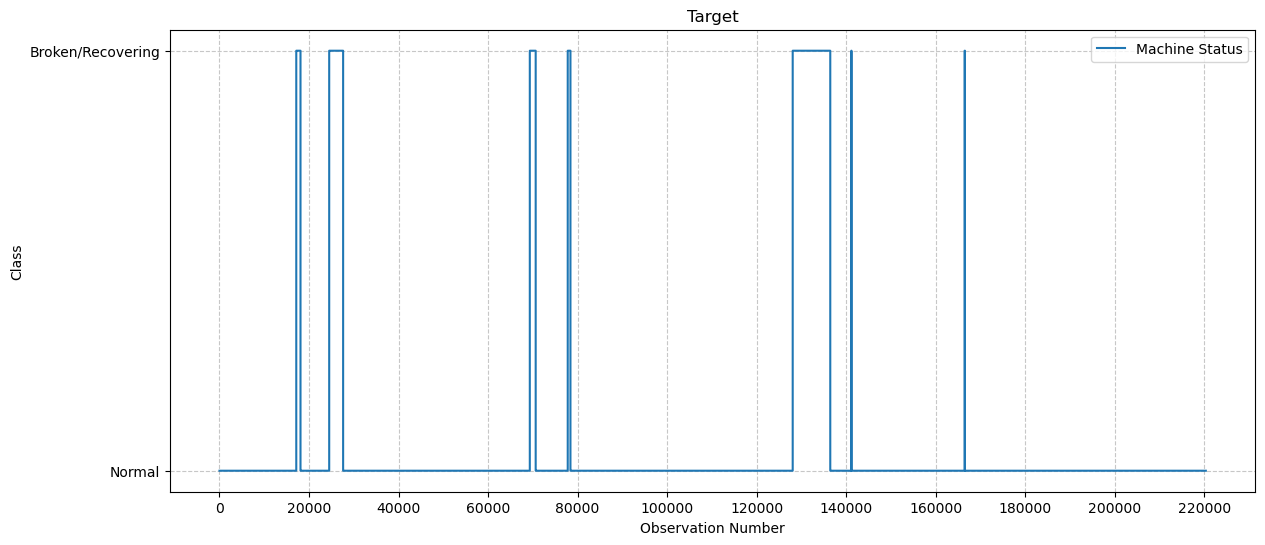

In [74]:
plt.figure(figsize=(14, 6))

# Use observation numbers as the x-axis
plt.step(range(len(df)), df['status_mapped'], label='Machine Status', where='mid')

# Set y-ticks to reflect all statuses
plt.yticks([0, 1], ['Normal', 'Broken/Recovering'])

# Set x-ticks at intervals of 20,000
x_ticks = range(0, len(df) + 1, 20000)
plt.xticks(ticks=x_ticks)

plt.xlabel('Observation Number')
plt.ylabel('Class')
plt.title('Target')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

This plot is used to visualize the machine's status over time or observation sequence. It helps identify patterns, transitions, and trends in the target variable (machine_status), which represents whether the machine is in a normal state or transitioning to a broken/recovering state.

By using observation numbers on the x-axis, we can easily pinpoint the regions for training, validation, and testing splits in a time series context without altering the original timestamp-based index.

In [77]:
# Create features and target columns
df_x = df.drop('status_mapped', axis=1)
df_y = df['status_mapped']

In [79]:
# Split the data into training, testing, and validation sets (before scaling)
train_X = df_x[0:130000]
train_Y = df_y[0:130000]

test_X = df_x[130000::]
test_Y = df_y[130000::]

train_X.shape,train_Y.shape,test_X.shape,test_Y.shape

((130000, 39), (130000,), (90320, 39), (90320,))

# **Standardize the numeric features**

* Scaling aligns feature distributions, preventing dominant features from overshadowing others.
* MinMaxScaler is chosen for its compatibility with deep learning models.
* Fitting only on the training data avoids data leakage and ensures proper generalization.
* Transforming test/validation sets separately ensures consistent preprocessing.
* The scaler is fit only on the training data to mimic real-world scenarios where unseen data is processed based on training data statistics. This prevents using information from the test or validation sets during training, ensuring fair and unbiased model evaluation.

In [82]:
# Scale the features
scaler = MinMaxScaler()

# Fit and transform the training set
train_X_scaled = scaler.fit_transform(train_X)

# Transform the test set
test_X_scaled = scaler.transform(test_X)

# Convert the scaled data back to DataFrame
train_X_scaled = pd.DataFrame(train_X_scaled, columns=train_X.columns)
test_X_scaled = pd.DataFrame(test_X_scaled, columns=test_X.columns)

# Check the shape of the datasets
train_X_scaled.shape, train_Y.shape, test_X_scaled.shape, test_Y.shape

((130000, 39), (130000,), (90320, 39), (90320,))

In [429]:
train_X_scaled.head()

,sensor_01,sensor_02,sensor_04,sensor_05,sensor_06,sensor_11,sensor_13,sensor_14,sensor_27,sensor_28,sensor_30,sensor_34,sensor_37,sensor_38,sensor_39,sensor_40,sensor_44,sensor_45,sensor_47,sensor_48,sensor_51,day,hour,minute,year_2018,month_4,month_5,month_6,month_7,month_8,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_weekend_0,is_weekend_1
0,0.45,0.73,0.55,0.55,0.40,0.70,0.05,0.59,0.35,0.42,0.30,0.32,0.52,0.28,0.36,0.49,0.36,1.00,0.30,0.31,0.52,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
1,0.45,0.73,0.55,0.55,0.40,0.70,0.05,0.59,0.35,0.42,0.30,0.32,0.52,0.28,0.36,0.49,0.36,1.00,0.30,0.31,0.52,0.00,0.00,0.02,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
2,0.47,0.73,0.63,0.49,0.38,0.72,0.05,0.62,0.41,0.42,0.50,0.31,0.54,0.31,0.35,0.48,0.35,1.00,0.30,0.30,0.53,0.00,0.00,0.03,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
3,0.45,0.73,0.44,0.56,0.38,0.73,0.05,0.62,0.46,0.42,0.57,0.30,0.58,0.32,0.36,0.51,0.34,1.00,0.30,0.30,0.53,0.00,0.00,0.05,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
4,0.46,0.73,0.58,0.55,0.38,0.74,0.05,0.60,0.30,0.42,0.41,0.30,0.58,0.34,0.36,0.56,0.33,1.00,0.31,0.31,0.52,0.00,0.00,0.07,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00


# **Modellling**


Data Preparation: Creating a Rolling Window for Features

Adjusted the data by setting up sequences that span the last 10 minutes and setting the target as the failure (broken status) at the 10-minute mark.

In [433]:
time_steps = 10  # 10 minutes input sequence
forecast_horizon = 10  # Predicting 10 minutes ahead

# Reshape the input features
train_X_seq, train_Y_seq = create_sequence_data(train_X_scaled, train_Y, time_steps, forecast_horizon)
test_X_seq, test_Y_seq = create_sequence_data(test_X_scaled, test_Y, time_steps, forecast_horizon)

# Check the shape
train_X_seq.shape, train_Y_seq.shape, test_X_seq.shape, test_Y_seq.shape

((129981, 10, 39), (129981,), (90301, 10, 39), (90301,))

### Base Model

**Building the LSTM Model for Classification**

We will create an LSTM-based classification model. The model will predict whether the system will fail (1) or not (0) in the next 10 minutes based on the last 10 minutes of sensor data.

In [436]:
input_shape = (train_X_seq.shape[1], train_X_seq.shape[2])
input_shape

(10, 39)

In [474]:
# Build the base model
model = Sequential([
        # LSTM layer to capture temporal patterns
        LSTM(50, input_shape=input_shape,
             kernel_regularizer=l2(0.001),  # Prevent overfitting
             return_sequences=False),  # No need to return sequences for the next layer

        # Fully connected layer for classification
        Dense(32, activation='relu'),  # Hidden dense layer with ReLU activation
        Dropout(0.2),  # Dropout to avoid overfitting

        # Output layer for binary classification
        Dense(1, activation='sigmoid')  # Sigmoid activation for classification (0/1)
    ])

optimizer=Adam(learning_rate=0.001)

model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',  # Loss function for classification
                 metrics=[Recall(), Precision(), 'accuracy'])

# Class weights for imbalanced data
class_weights = {0: 1, 1: len(train_Y_seq) / (2 * sum(train_Y_seq))}  # Class 1 is the minority class

model.summary()

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_recall_6',  # Monitor validation recall
    mode='max',
    patience=10,  # Stop if no improvement for 15 epochs
    verbose=1,
    restore_best_weights=True  # Restore the best model weights
)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 50)             │        18,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,665 (76.82 KB)

 Trainable params: 19,665 (76.82 KB)

 Non-trainable params: 0 (0.00 B)

In [476]:
start_time = datetime.datetime.now()

# Train the model with the reshaped sequence data and class weights
history = model.fit(train_X_seq, train_Y_seq,
                    validation_data=(test_X_seq, test_Y_seq),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping],
                    class_weight=class_weights,  # Apply class weights for imbalanced data
                    verbose=2)

end_time = datetime.datetime.now()
total_duration = end_time - start_time
print("Training Time:", total_duration)

Epoch 1/100
4062/4062 - 25s - 6ms/step - accuracy: 0.9925 - loss: 0.0618 - precision_6: 0.9003 - recall_6: 0.9855 - val_accuracy: 0.9913 - val_loss: 0.0762 - val_precision_6: 0.9010 - val_recall_6: 0.9885
Epoch 2/100
4062/4062 - 26s - 6ms/step - accuracy: 0.9959 - loss: 0.0286 - precision_6: 0.9415 - recall_6: 0.9947 - val_accuracy: 0.9851 - val_loss: 0.0636 - val_precision_6: 0.9072 - val_recall_6: 0.8844
Epoch 3/100
4062/4062 - 37s - 9ms/step - accuracy: 0.9958 - loss: 0.0261 - precision_6: 0.9394 - recall_6: 0.9956 - val_accuracy: 0.9751 - val_loss: 0.1081 - val_precision_6: 0.8786 - val_recall_6: 0.7611
Epoch 4/100
4062/4062 - 25s - 6ms/step - accuracy: 0.9968 - loss: 0.0228 - precision_6: 0.9534 - recall_6: 0.9955 - val_accuracy: 0.9777 - val_loss: 0.1014 - val_precision_6: 0.8797 - val_recall_6: 0.8015
Epoch 5/100
4062/4062 - 24s - 6ms/step - accuracy: 0.9967 - loss: 0.0232 - precision_6: 0.9514 - recall_6: 0.9962 - val_accuracy: 0.9703 - val_loss: 0.1397 - val_precision_6: 0.860

The recall is used as a metric because it measures the proportion of actual positives that are correctly identified by the model. This is particularly important in scenarios where identifying all positive cases (e.g., "broken" components in predictive maintenance) is critical, even if it means allowing some false positives.

Based on the metrics provided, the validation recall is consistently high, but there is a noticeable gap between training and validation performance. For example, at Epoch 14, the training recall is 0.9855, whereas the validation recall is 0.9885.

This suggests that the model performs well in identifying positives across both the training and validation datasets but shows signs of overfitting as the validation loss increases (0.0762 at Epoch 1). Despite the strong recall, the lower validation precision (0.9010) indicates a trade-off, where the model might predict more false positives to ensure higher recall.

### Performance Evaluation

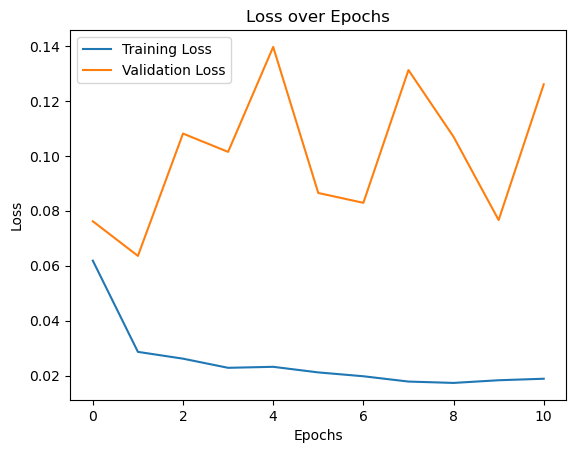

In [481]:
# Train and validation plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

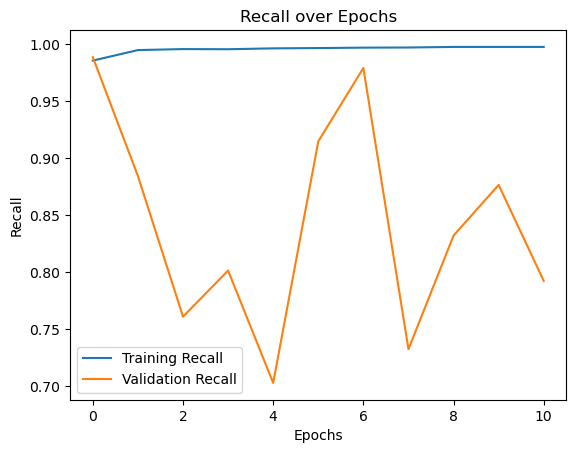

In [485]:
# F1_score metrics plot
plt.plot(history.history['recall_6'], label='Training Recall')
plt.plot(history.history['val_recall_6'], label='Validation Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

2822/2822 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


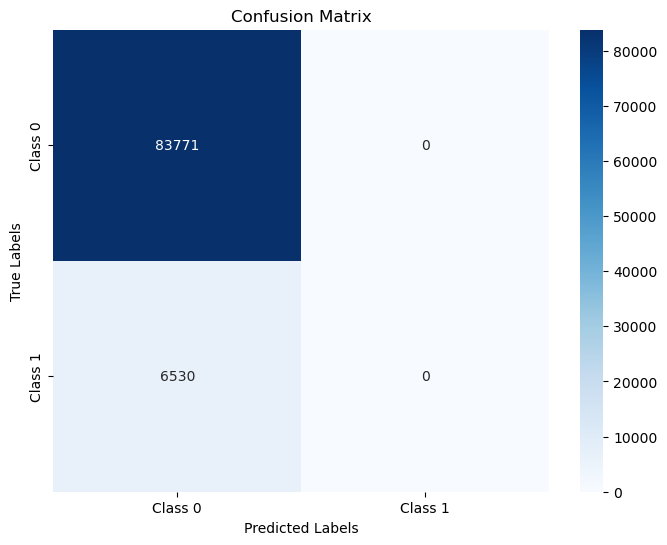

In [487]:
# Make predictions
y_pred = model.predict(test_X_seq)
y_pred_classes = np.argmax(y_pred, axis=1)  # Assuming model output is one-hot encoded

# Check if test_Y_seq is already 1D or one-hot encoded
if len(test_Y_seq.shape) > 1:
    y_true = np.argmax(test_Y_seq, axis=1)  # Only if the labels are one-hot encoded
else:
    y_true = test_Y_seq  # If it's already 1D class labels

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [489]:
test_results = model.evaluate(test_X_seq, test_Y_seq, verbose=1)
print(f"Test Recall: {test_results[3]}")
print(f"Test Loss: {test_results[0]}")

2822/2822 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9855 - loss: 0.1353 - precision_6: 0.9252 - recall_6: 0.9913
Test Recall: 0.9913179278373718
Test Loss: 0.0761776864528656


#  SMOTE Oversampling for Time-Series Data

In [492]:
# Check the class distribution
print("Original Class Distribution:", np.bincount(train_Y))

# Define the sampling_strategy to bring the minority class to 35%
minority_class_ratio = 0.35 

# Calculate the target count for the minority class
majority_class_count = np.sum(train_Y == 0)  
target_minority_class_count = int(majority_class_count * minority_class_ratio / (1 - minority_class_ratio))

# Apply SMOTE
smote = SMOTE(sampling_strategy={1: target_minority_class_count}, random_state=42)
X_resampled, Y_resampled = smote.fit_resample(train_X, train_Y)

# Check the new class distribution
print("New Class Distribution:", np.bincount(Y_resampled))

Original Class Distribution: [122065   7935]
New Class Distribution: [122065  65727]


In [494]:
# Scale the features
scaler = MinMaxScaler()

# Fit and transform the training set
train_X_scaled = scaler.fit_transform(X_resampled)


# Convert the scaled data back to DataFrame
train_X_scaled = pd.DataFrame(train_X_scaled, columns=X_resampled.columns)

# Check the shape of the datasets
print(train_X_scaled.shape, Y_resampled.shape)

(187792, 39) (187792,)


In [496]:
# Reshape the input features
time_steps = 10  # 10 minutes input sequence
forecast_horizon = 10  # Predicting 10 minutes ahead

train_X_seq, train_Y_seq = create_sequence_data(train_X_scaled, Y_resampled, time_steps, forecast_horizon)

# Check the shape of the resulting sequences
print(train_X_seq.shape, train_Y_seq.shape)


(187773, 10, 39) (187773,)


In [497]:
input_shape = (train_X_seq.shape[1], train_X_seq.shape[2])
input_shape

(10, 39)

In [504]:
# Build the base model
model = Sequential([
        # LSTM layer to capture temporal patterns
        LSTM(50, input_shape=input_shape,
             kernel_regularizer=l2(0.001),  # Prevent overfitting
             return_sequences=False),  # No need to return sequences for the next layer

        # Fully connected layer for classification
        Dense(32, activation='relu'),  # Hidden dense layer with ReLU activation
        Dropout(0.2),  # Dropout to avoid overfitting

        # Output layer for binary classification
        Dense(1, activation='sigmoid')  # Sigmoid activation for classification (0/1)
    ])
optimizer=Adam(learning_rate=0.001)

model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',  # Loss function for classification
                 metrics=[Recall(), Precision(), 'accuracy'])

model.summary()

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_recall_8',  # Monitor validation recall
    mode='max',
    patience=10,  # Stop if no improvement for 15 epochs
    verbose=1,
    restore_best_weights=True  # Restore the best model weights
)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 50)             │        18,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,665 (76.82 KB)

 Trainable params: 19,665 (76.82 KB)

 Non-trainable params: 0 (0.00 B)

In [506]:
# Train the model
start_time = datetime.datetime.now()

history = model.fit(train_X_seq, train_Y_seq,
                    validation_data=(test_X_seq, test_Y_seq),
                    epochs=100,
                    batch_size=16,
                    callbacks=[early_stopping],
                    #class_weight=class_weights,  # Apply class weights
                    verbose=2)

end_time = datetime.datetime.now()
total_duration = end_time - start_time
print("Training Time:", total_duration)

Epoch 1/100
11736/11736 - 55s - 5ms/step - accuracy: 0.9966 - loss: 0.0188 - precision_8: 0.9962 - recall_8: 0.9939 - val_accuracy: 0.9746 - val_loss: 0.0714 - val_precision_8: 0.9373 - val_recall_8: 0.6954
Epoch 2/100
11736/11736 - 59s - 5ms/step - accuracy: 0.9983 - loss: 0.0088 - precision_8: 0.9982 - recall_8: 0.9970 - val_accuracy: 0.9763 - val_loss: 0.0704 - val_precision_8: 0.9219 - val_recall_8: 0.7340
Epoch 3/100
11736/11736 - 57s - 5ms/step - accuracy: 0.9986 - loss: 0.0071 - precision_8: 0.9986 - recall_8: 0.9974 - val_accuracy: 0.9809 - val_loss: 0.0723 - val_precision_8: 0.8754 - val_recall_8: 0.8582
Epoch 4/100
11736/11736 - 56s - 5ms/step - accuracy: 0.9987 - loss: 0.0066 - precision_8: 0.9986 - recall_8: 0.9975 - val_accuracy: 0.9765 - val_loss: 0.1029 - val_precision_8: 0.9470 - val_recall_8: 0.7144
Epoch 5/100
11736/11736 - 54s - 5ms/step - accuracy: 0.9987 - loss: 0.0066 - precision_8: 0.9985 - recall_8: 0.9978 - val_accuracy: 0.9723 - val_loss: 0.1086 - val_precisio

The model is performing well, with high accuracy (98.09%) and recall (58.82%) on the training set, and 99.86% accuracy and 99.74% recall on the validation set. Precision is also high, indicating minimal false positives. The slight difference between training and validation metrics suggests good generalization, though overfitting could be a concern if the gap widens in later epochs. SMOTE(Oversampling) has effectively helped balance the classes, improving the model's ability to detect the minority class. Overall, the model is strong, but monitoring for overfitting is advised.

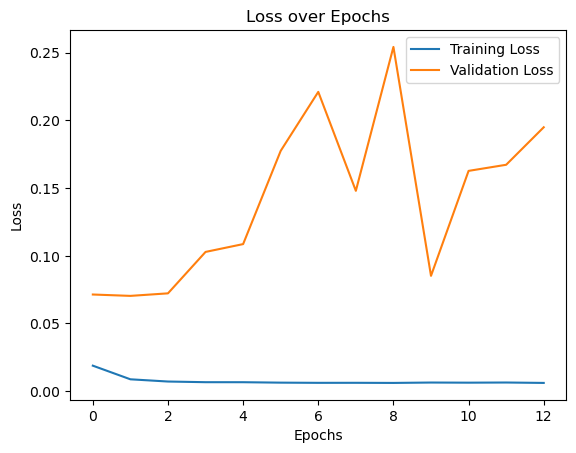

In [515]:
# Train and validation loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

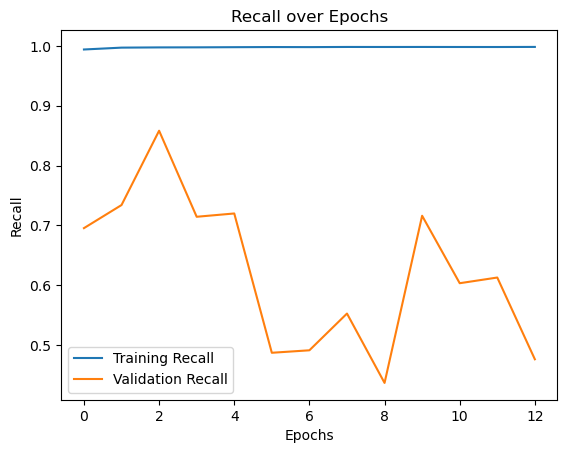

In [517]:
# Recall metrics plot
plt.plot(history.history['recall_8'], label='Training Recall')
plt.plot(history.history['val_recall_8'], label='Validation Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [519]:
test_results = model.evaluate(test_X_seq, test_Y_seq, verbose=1)
print(f"Test Loss: {test_results[0]}")
print(f"Test Recall: {test_results[3]}")
print(f"Test Precision: {test_results[2]}")
print(f"Test Accuracy: {test_results[1]}")

2822/2822 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9521 - loss: 0.1733 - precision_8: 0.8972 - recall_8: 0.8673
Test Loss: 0.8581929802894592
Test Recall: 0.9809082746505737
Test Precision: 0.8753514289855957
Test Accuracy: 0.07225538790225983


#  SMOTE Undersampling for Time-Series Data

In [84]:
# Check the class distribution
print("Original Class Distribution:", np.bincount(train_Y))

# Define the undersampling strategy for a 35% minority class ratio
minority_class_ratio = 0.40  

# Calculate the target count for the majority class
minority_class_count = np.sum(train_Y == 1)  
target_majority_class_count = int(minority_class_count * (1 - minority_class_ratio) / minority_class_ratio)

# Undersampling while preserving the temporal order
majority_indices = np.where(train_Y == 0)[0]
minority_indices = np.where(train_Y == 1)[0]

# Select the first N samples from the majority class to match the target size
undersampled_majority_indices = majority_indices[:target_majority_class_count]

# Combine undersampled majority class indices with all minority class indices
undersampled_indices = np.sort(np.concatenate([undersampled_majority_indices, minority_indices]))

# If train_X and train_Y are pandas objects, use .iloc for indexing
if isinstance(train_X, pd.DataFrame) or isinstance(train_X, pd.Series):
    X_resampled = train_X.iloc[undersampled_indices]
    Y_resampled = train_Y.iloc[undersampled_indices]
else:
    # If train_X and train_Y are NumPy arrays, use array slicing
    X_resampled = train_X[undersampled_indices]
    Y_resampled = train_Y[undersampled_indices]

# Check the new class distribution
print("New Class Distribution:", np.bincount(Y_resampled))

Original Class Distribution: [122065   7935]
New Class Distribution: [11902  7935]


In [524]:
# Scale the features
scaler = MinMaxScaler()

# Fit and transform the training set
train_X_scaled = scaler.fit_transform(X_resampled)

# Transform the test set
test_X_scaled = scaler.transform(test_X)

# Convert the scaled data back to DataFrame
train_X_scaled = pd.DataFrame(train_X_scaled, columns=X_resampled.columns)
test_X_scaled = pd.DataFrame(test_X_scaled, columns=test_X.columns)

# Check the shape of the datasets
train_X_scaled.shape, train_Y.shape, test_X_scaled.shape, test_Y.shape

((19837, 39), (130000,), (90320, 39), (90320,))

In [526]:
time_steps = 10  # 10 minutes input sequence
forecast_horizon = 10  # Predicting 10 minutes ahead

# Reshape the input features
train_X_seq, train_Y_seq = create_sequence_data(train_X_scaled, train_Y, time_steps, forecast_horizon)
test_X_seq, test_Y_seq = create_sequence_data(test_X_scaled, test_Y, time_steps, forecast_horizon)

# Check the shape
train_X_seq.shape, train_Y_seq.shape, test_X_seq.shape, test_Y_seq.shape

((19818, 10, 39), (19818,), (90301, 10, 39), (90301,))

In [527]:
input_shape = (train_X_seq.shape[1], train_X_seq.shape[2])
input_shape

(10, 39)

In [530]:
start_time = datetime.datetime.now()

history = model.fit(train_X_seq, train_Y_seq,
                    validation_data=(test_X_seq, test_Y_seq),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=2)

end_time = datetime.datetime.now()
total_duration = end_time - start_time
print("Training Time:", total_duration)

Epoch 1/100
620/620 - 14s - 22ms/step - accuracy: 0.9889 - loss: 0.0526 - precision_8: 0.9106 - recall_8: 0.8519 - val_accuracy: 0.7967 - val_loss: 0.6757 - val_precision_8: 0.0147 - val_recall_8: 0.0274
Epoch 2/100
620/620 - 19s - 31ms/step - accuracy: 0.9955 - loss: 0.0156 - precision_8: 0.9572 - recall_8: 0.9471 - val_accuracy: 0.6461 - val_loss: 1.4753 - val_precision_8: 0.0086 - val_recall_8: 0.0342
Epoch 3/100
620/620 - 19s - 31ms/step - accuracy: 0.9960 - loss: 0.0131 - precision_8: 0.9596 - recall_8: 0.9556 - val_accuracy: 0.5936 - val_loss: 1.9963 - val_precision_8: 0.0233 - val_recall_8: 0.1127
Epoch 4/100
620/620 - 11s - 18ms/step - accuracy: 0.9961 - loss: 0.0127 - precision_8: 0.9559 - recall_8: 0.9630 - val_accuracy: 0.7297 - val_loss: 1.1387 - val_precision_8: 0.1233 - val_recall_8: 0.4481
Epoch 5/100
620/620 - 13s - 21ms/step - accuracy: 0.9974 - loss: 0.0101 - precision_8: 0.9705 - recall_8: 0.9757 - val_accuracy: 0.5771 - val_loss: 2.6200 - val_precision_8: 0.0634 - v

The model exhibits clear signs of overfitting, as indicated by the stark contrast between the training and validation performance metrics. While the training accuracy and loss are excellent (accuracy: 99.61%, loss: 0.0127), the validation accuracy is significantly lower at 72.97%, and the validation loss is much higher at 1.1387. The validation precision (12.33%) is particularly low compared to the training precision (95.59%), highlighting poor generalization. Despite a relatively high validation recall (44.81%), the low precision suggests the model is predicting too many false positives, reinforcing the overfitting concern.

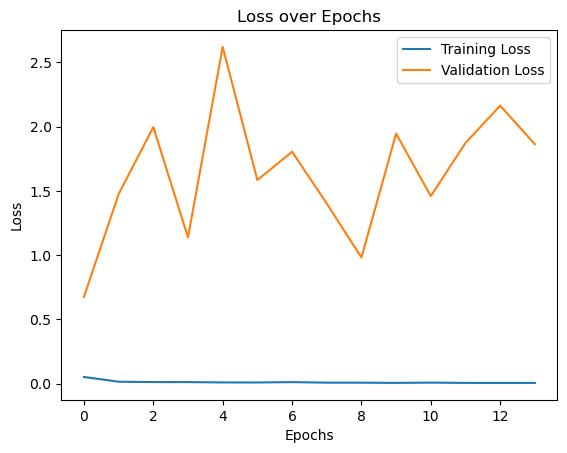

In [531]:
# Train and validation loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

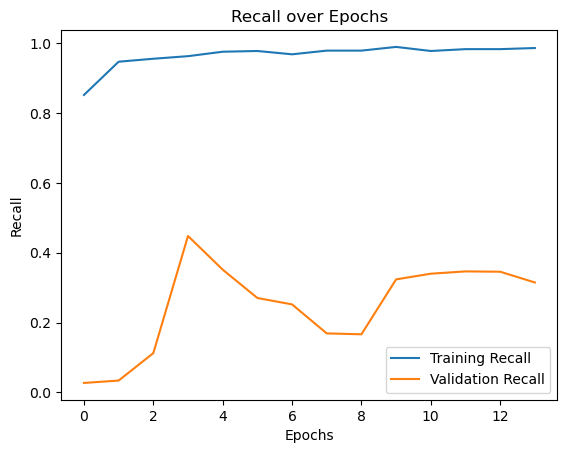

In [532]:
# Recall metrics plot
plt.plot(history.history['recall_8'], label='Training Recall')
plt.plot(history.history['val_recall_8'], label='Validation Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

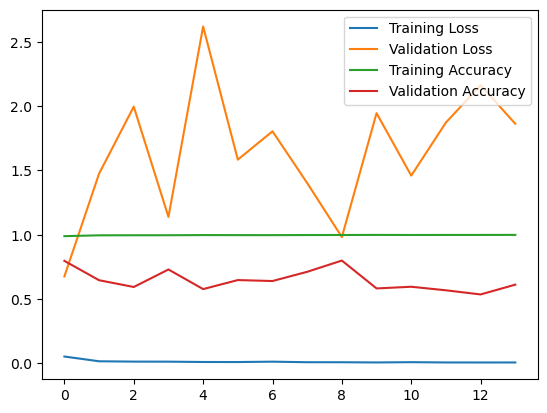

In [533]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [534]:
test_results = model.evaluate(test_X_seq, test_Y_seq, verbose=1)
print(f"Test Loss: {test_results[0]}")
print(f"Test Recall: {test_results[1]}")
print(f"Test Precision: {test_results[2]}")
print(f"Test Accuracy: {test_results[3]}")

2822/2822 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5867 - loss: 2.0904 - precision_8: 0.2794 - recall_8: 0.4295
Test Loss: 1.1386842727661133
Test Recall: 0.448085755109787
Test Precision: 0.12329863756895065
Test Accuracy: 0.7296929359436035


# Hyperparameter Optimization

### Build Search Space

In [537]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=input_shape))

    # LSTM layers
    for i in range(hp.Int('num_layers', 1, 5)):  # The upper limit can be increased for deeper networks
        model.add(LSTM(
            units=hp.Int(f'units_layer_{i}', min_value=32, max_value=256, step=32),  # Optimal unit range
            return_sequences=(i < hp.Int('num_layers', 1, 5) - 1),  # return_sequences=False for the last layer
            kernel_regularizer=l2(hp.Float(f'l2_layer_{i}', min_value=1e-5, max_value=1e-3, sampling='LOG')),  # Regularization
            recurrent_dropout=hp.Float(f'recurrent_dropout_layer_{i}', min_value=0.0, max_value=0.5, step=0.1)  # Recurrent dropout
        ))
        model.add(BatchNormalization())  # To normalize
        model.add(Dropout(hp.Float(f'dropout_layer_{i}', min_value=0.0, max_value=0.5, step=0.1)))  # Adding dropout

    # Fully connected layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=16, max_value=128, step=16),
        activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'])
    ))
    model.add(Dropout(hp.Float('dense_dropout', min_value=0.0, max_value=0.5, step=0.1)))  # Dropout in the fully connected layer

    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

    # Optimization parameters
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop', 'adamax'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')  # Log-scale for learning rate

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum=hp.Float('momentum', 0.0, 0.9, step=0.1))
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adamax':
        opt = Adamax(learning_rate=learning_rate)

    model.compile(optimizer=opt,
                  loss='binary_crossentropy',  # Appropriate loss for binary classification
                  metrics=[Recall(), Precision(), 'accuracy'])  # Classification metrics

    return model

In [538]:
# Random Search Tuner
random_search_tuner = RandomSearch(
    build_model,
    objective=keras_tuner.Objective('val_recall', direction='max'),  # 'Recall' is targeted due to imbalanced data
    max_trials=10,  # Increased to explore a wider range of hyperparameters
    executions_per_trial=2,  # Each combination is run twice for stability
    directory='hyperparam_tuning',
    project_name='lstm_tuning',
    overwrite=True  # Overwrites previous results
)

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_recall',  # Targeting recall
    mode='max',  # Aim is to maximize recall
    patience=10,  # Increased patience for longer training
    verbose=1,
    restore_best_weights=True  # Restores the best weights
)

In [ ]:
random_search_tuner.search(
    train_X_seq, train_Y_seq,
    epochs=200,  # Runs for a maximum of 500 epochs
    validation_data=(test_X_seq, test_Y_seq),  # Validation set is used for evaluation
    callbacks=[early_stopping],  # Prevents overfitting with early stopping
    batch_size=16,  # Optional: Batch size can be added
    verbose=2
)

# Summary of tuning results
random_search_tuner.results_summary()

**Note:** Despite high training accuracy and recall, the validation precision is significantly low (0.0075) with a moderate recall (0.8814), indicating potential overfitting,

In [ ]:
# Retrieve the best hyperparameter combination
best_hps = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

In [ ]:
# Retrain the model
best_hps.fit(
    train_X_seq, train_Y_seq,
    validation_data=(test_X_seq, test_Y_seq),
    epochs=50,
    callbacks=[early_stopping],
    batch_size=32
)

In [ ]:
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

In [ ]:
# Save the model in HDF5 format
best_hps.save('best_model_lstm.h5')

# Save in SavedModel format (default TensorFlow format)
best_hps.save('saved_model_lstm')

In [ ]:
# Save the weights
best_hps.save_weights('best_model_weights_lstm.h5')

In [ ]:
# Train and validation loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# F1_score metrics plot
plt.plot(history.history['f1_score'], label='Training F1_score')
plt.plot(history.history['val_f1_score'], label='Validation F1_score')
plt.title('F1_score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.legend()
plt.show()

# ML Pipeline

In [86]:
def evaluate_models_with_cv(X, y, n_splits=5):
    print("Evaluating Models with 5-Fold Time Series Cross-Validation....")

    # Reset indices to avoid alignment issues
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    classifiers = [
        ('LR', LogisticRegression(max_iter=1000, class_weight='balanced')),
        ('KNN', KNeighborsClassifier()),
        ('CART', DecisionTreeClassifier(class_weight='balanced')),
        ('RF', RandomForestClassifier(class_weight='balanced')),
        ('Adaboost', AdaBoostClassifier()),
        ('GBM', GradientBoostingClassifier()),
        ('XGBoost', XGBClassifier(eval_metric='logloss', use_label_encoder=False))
    ]

    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = {}
    best_model = None
    best_f1 = 0

    for name, classifier in classifiers:
        print(f"\nTraining {name} with Cross-Validation...")
        cv_results = []
        feature_importances = []

        for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
            print(f"Fold {fold + 1}...")

            # Split data
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Transform the test set
            X_test = scaler.transform(X_test)
            X_test = pd.DataFrame(X_test, columns=X.columns)

            # Train and predict
            classifier.fit(X_train, y_train)
            y_pred_test = classifier.predict(X_test)

            # Debugging predictions
            print(f"Unique predictions in y_pred_test: {np.unique(y_pred_test)}")

            # Compute metrics
            metrics_test = {
                'accuracy': accuracy_score(y_test, y_pred_test),
                'precision': precision_score(y_test, y_pred_test, zero_division=1),
                'recall': recall_score(y_test, y_pred_test, zero_division=1),
                'f1': f1_score(y_test, y_pred_test, zero_division=1),
            }

            # Calculate ROC-AUC if predictions contain more than one class
            if len(np.unique(y_pred_test)) > 1:
                metrics_test['roc_auc'] = roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
            else:
                metrics_test['roc_auc'] = np.nan

            cv_results.append(metrics_test)

            # Collect feature importances if available
            if hasattr(classifier, 'feature_importances_'):
                feature_importances.append(classifier.feature_importances_)

        # Average results across folds
        avg_metrics = pd.DataFrame(cv_results).mean().to_dict()
        results[name] = {metric: round(score, 4) for metric, score in avg_metrics.items()}

        # Check if this model is the best so far
        if avg_metrics['f1'] > best_f1:
            best_f1 = avg_metrics['f1']
            best_model = (name, classifier, cv_results, X_test, y_test, y_pred_test, feature_importances)

        print(f"{name} Cross-Validation Results: {results[name]}")

    # Plot metrics for the best model
    if best_model:
        plot_best_model_results(*best_model)

    return results

def plot_best_model_results(name, classifier, cv_results, X_test, y_test, y_pred_test, feature_importances):
    print(f"\nBest Model: {name}")
    print(f"Metrics: {cv_results}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Feature Importances
    if feature_importances:
        avg_importances = np.mean(feature_importances, axis=0)
        importance_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': avg_importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)

        plt.figure(figsize=(8, 6))
        sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
        plt.title(f"{name} - Top 15 Feature Importances")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.show()

    # Metrics Plot
    metrics_df = pd.DataFrame(cv_results)
    metrics_df.plot(kind='line', figsize=(10, 6))
    plt.title(f"{name} - Cross-Validation Metrics")
    plt.xlabel("Fold")
    plt.ylabel("Score")
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [99]:
#target_col = 'status_mapped'

# Balancing the Data
train_X_balanced, train_y_balanced = balance_data(df_x, df_y)

In [101]:
# Scale the features
scaler = MinMaxScaler()

# Fit and transform the training set
train_X_scaled = scaler.fit_transform(train_X_balanced)

# Transform the test set
test_X_scaled = scaler.transform(test_X)

# Convert the scaled data back to DataFrame
train_X_scaled = pd.DataFrame(train_X_scaled, columns=X_resampled.columns)
test_X_scaled = pd.DataFrame(test_X_scaled, columns=test_X.columns)

# Check the shape of the datasets
train_X_scaled.shape, train_Y.shape, test_X_scaled.shape, test_Y.shape

((46670, 39), (130000,), (90320, 39), (90320,))

### Base Logistic Regression Model

In [106]:
# Logistic Reg.
log_model = LogisticRegression().fit(train_X_balanced, train_y_balanced)
y_pred = log_model.predict(train_X_scaled)

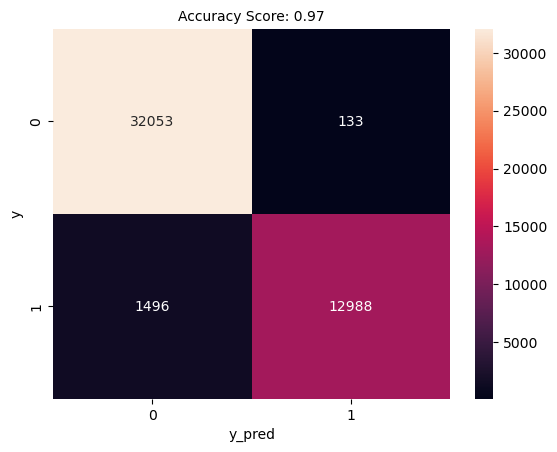

In [108]:
# Model Evaluation
plot_confusion_matrix_ml(train_y_balanced,y_pred)

In [110]:
print(classification_report(train_y_balanced,y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     32186
           1       0.99      0.90      0.94     14484

    accuracy                           0.97     46670
   macro avg       0.97      0.95      0.96     46670
weighted avg       0.97      0.97      0.96     46670



In [112]:
# ROC AUC

y_prob = log_model.predict_proba(train_X_scaled)[:, 1]
roc_auc_score(train_y_balanced,y_pred)

0.9462906918092577

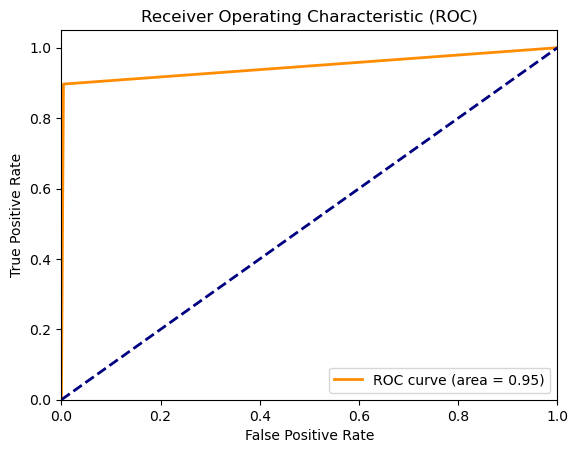

In [114]:
# ROC Curve

fpr, tpr, thresholds = roc_curve(train_y_balanced,y_pred)

# AUC

roc_auc = roc_auc_score(train_y_balanced,y_pred)

# ROC Curve Plot

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [116]:
# Model Validation
# Split the data into training and testing sets (before scaling)
X_train = df_x[0:130000]
y_train = df_y[0:130000]

X_test = df_x[130000::]
y_test = df_y[130000::]

In [118]:
# Scale the features
scaler = MinMaxScaler()

# Fit and transform the training set
train_X_scaled = scaler.fit_transform(X_train)

# Transform the test set
test_X_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame
train_X_scaled = pd.DataFrame(train_X_scaled, columns=X_train.columns)
test_X_scaled = pd.DataFrame(test_X_scaled, columns=X_test.columns)

In [120]:
log_model = LogisticRegression().fit(train_X_scaled, y_train)
y_pred = log_model.predict(test_X_scaled)
y_prob = log_model.predict_proba(test_X_scaled)[:,1]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     83771
           1       0.90      0.99      0.94      6549

    accuracy                           0.99     90320
   macro avg       0.95      0.99      0.97     90320
weighted avg       0.99      0.99      0.99     90320



In [122]:
# Predict probabilities for the test set
y_prob = log_model.predict_proba(test_X_scaled)[:, 1]

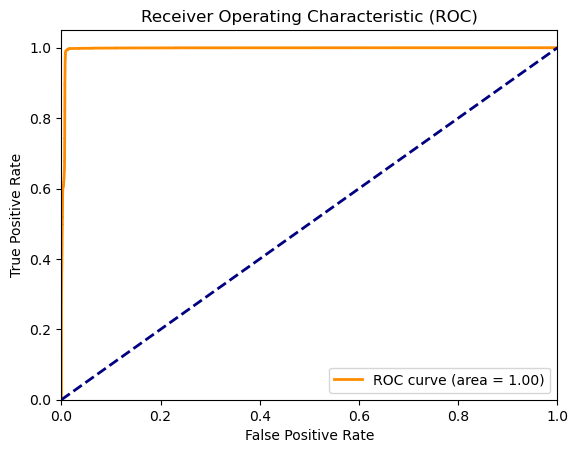

AUC Score: 1.00


In [124]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print AUC score
print(f'AUC Score: {roc_auc:.2f}')

### Other Classifications Methods

In [127]:
# Balancing the Data
train_X_balanced, train_y_balanced = balance_data(df_x, df_y)

In [129]:
scaler = MinMaxScaler()
train_X_scaled = scaler.fit_transform(train_X_balanced)
train_X_scaled = pd.DataFrame(train_X_scaled, columns=train_X_balanced.columns)

In [131]:
def evaluate_models_with_plots(X, y):
    print("Evaluating Models...\n")
    classifiers = [
        ('LR', LogisticRegression(max_iter=1000)),
        ('KNN', KNeighborsClassifier()),
        ('SVC', SVC(probability=True)),
        ('CART', DecisionTreeClassifier()),
        ('RF', RandomForestClassifier()),
        ('Adaboost', AdaBoostClassifier()),
        ('GBM', GradientBoostingClassifier()),
        ('XGBoost', XGBClassifier(eval_metric='logloss')),
        ('LightGBM', LGBMClassifier(verbose=-1))
    ]

    results = []
    tscv = TimeSeriesSplit(n_splits=5)

    for name, model in classifiers:
        print(f"Training {name}...")
        train_metrics = {'f1': [], 'precision': [], 'recall': [], 'roc_auc': []}
        test_metrics = {'f1': [], 'precision': [], 'recall': [], 'roc_auc': []}
        best_fold_index, best_fold_X_train, best_fold_X_test = None, None, None
        best_fold_y_train, best_fold_y_test, y_pred_test = None, None, None
        best_f1_score = -1

        for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            if len(y_test.unique()) < 2:  # Skip folds with only one class
                print(f"Skipping fold {fold} for {name} due to lack of class diversity in y_test.")
                continue

            model.fit(X_train, y_train)

            # Predictions
            train_pred = model.predict(X_train)
            test_pred = model.predict(X_test)

            # Probabilities
            train_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None
            test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

            # Train Metrics
            train_metrics['f1'].append(f1_score(y_train, train_pred))
            train_metrics['precision'].append(precision_score(y_train, train_pred, zero_division=0))
            train_metrics['recall'].append(recall_score(y_train, train_pred, zero_division=0))
            if train_proba is not None:
                train_metrics['roc_auc'].append(roc_auc_score(y_train, train_proba))

            # Test Metrics
            fold_f1 = f1_score(y_test, test_pred)
            test_metrics['f1'].append(fold_f1)
            test_metrics['precision'].append(precision_score(y_test, test_pred, zero_division=0))
            test_metrics['recall'].append(recall_score(y_test, test_pred, zero_division=0))
            if test_proba is not None:
                test_metrics['roc_auc'].append(roc_auc_score(y_test, test_proba))

            # Track best fold
            if fold_f1 > best_f1_score:
                best_f1_score = fold_f1
                best_fold_index = fold
                best_fold_X_train, best_fold_X_test = X_train, X_test
                best_fold_y_train, best_fold_y_test = y_train, y_test
                y_pred_test = test_pred

        # Aggregate Metrics
        train_mean_metrics = {k: np.mean(v) for k, v in train_metrics.items() if v}
        test_mean_metrics = {k: np.mean(v) for k, v in test_metrics.items() if v}

        results.append((name, train_mean_metrics, test_mean_metrics))

        # Print Metrics
        print(f"\n{name} Results:")
        print(f"Train: F1={train_mean_metrics['f1']:.4f}, Precision={train_mean_metrics['precision']:.4f}, "
              f"Recall={train_mean_metrics['recall']:.4f}, ROC AUC={train_mean_metrics['roc_auc']:.4f}")
        print(f"Test:  F1={test_mean_metrics['f1']:.4f}, Precision={test_mean_metrics['precision']:.4f}, "
              f"Recall={test_mean_metrics['recall']:.4f}, ROC AUC={test_mean_metrics['roc_auc']:.4f}")

        # Plot Feature Importance (if applicable)
        if hasattr(model, "feature_importances_"):
            plt.figure(figsize=(10, 5))
            plt.title(f"Feature Importance for {name}")
            importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
            sns.barplot(x=importances[:20], y=importances.index[:20])
            plt.xlabel("Importance")
            plt.ylabel("Feature")
            plt.show()

        # Plot Confusion Matrix
        if best_fold_y_train is not None and len(best_fold_y_train.unique()) == 2:
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            sns.heatmap(confusion_matrix(best_fold_y_train, model.predict(best_fold_X_train)), annot=True, fmt='d', ax=axes[0], cmap='Blues')
            axes[0].set_title(f"Train Confusion Matrix - {name}")
            sns.heatmap(confusion_matrix(best_fold_y_test, y_pred_test), annot=True, fmt='d', ax=axes[1], cmap='Blues')
            axes[1].set_title(f"Test Confusion Matrix - {name}")
            plt.show()

        # Plot Train vs. Test Predictions
        if best_fold_y_train is not None and y_pred_test is not None:
            plt.figure(figsize=(14, 8))
            plt.plot(
                range(len(best_fold_y_train)),
                best_fold_y_train,
                marker='o',
                linestyle='-',
                label="Train Actual",
                alpha=0.7,
            )
            plt.plot(
                range(len(best_fold_y_train)),
                model.predict(best_fold_X_train),
                marker='x',
                linestyle='--',
                label="Train Predicted",
                alpha=0.7,
            )
            plt.plot(
                range(len(best_fold_y_train), len(best_fold_y_train) + len(best_fold_y_test)),
                best_fold_y_test,
                marker='o',
                linestyle='-',
                label="Test Actual",
                alpha=0.7,
            )
            plt.plot(
                range(len(best_fold_y_train), len(best_fold_y_train) + len(best_fold_y_test)),
                y_pred_test,
                marker='x',
                linestyle='--',
                label="Test Predicted",
                alpha=0.7,
            )
            plt.title(f"Train vs. Test Predictions - {name} (Best Fold {best_fold_index})")
            plt.xlabel("Time Steps")
            plt.ylabel("Target Value")
            plt.legend()
            plt.grid()
            plt.show()

    # Summarize Results
    print("\nFinal Model Performance Summary:")
    for name, train_metrics, test_metrics in results:
        print(f"{name}: Train F1={train_metrics['f1']:.4f}, Test F1={test_metrics['f1']:.4f}")

    return results

Evaluating Models...

Training LR...
Skipping fold 5 for LR due to lack of class diversity in y_test.

LR Results:
Train: F1=0.9907, Precision=0.9846, Recall=0.9969, ROC AUC=0.9998
Test:  F1=0.6254, Precision=0.7089, Recall=0.5791, ROC AUC=0.9664


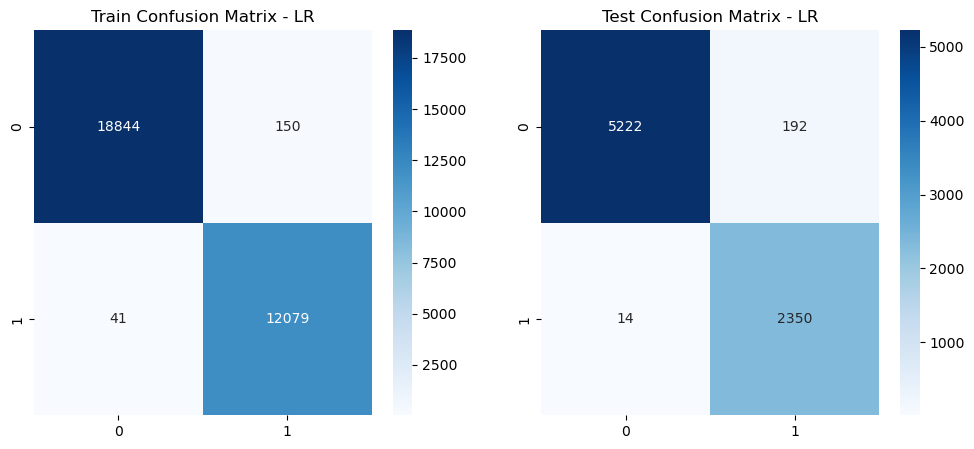

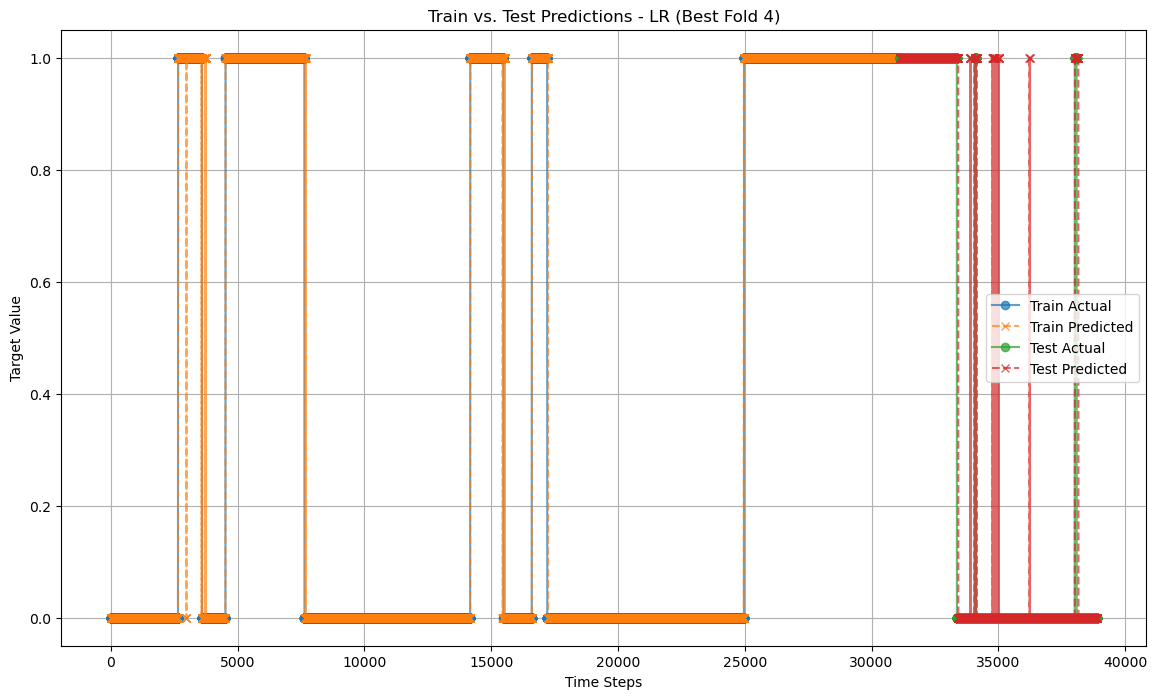

Training KNN...
Skipping fold 5 for KNN due to lack of class diversity in y_test.

KNN Results:
Train: F1=0.9989, Precision=0.9978, Recall=1.0000, ROC AUC=1.0000
Test:  F1=0.2369, Precision=0.2343, Recall=0.2396, ROC AUC=0.6151


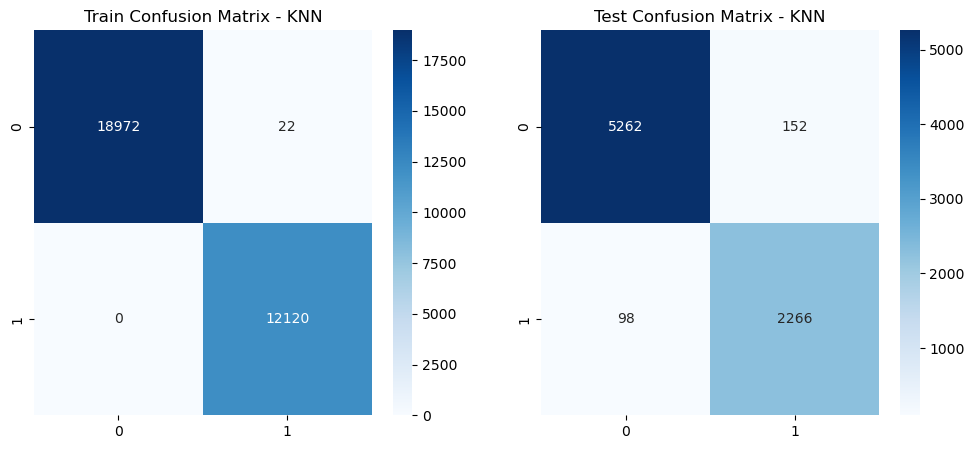

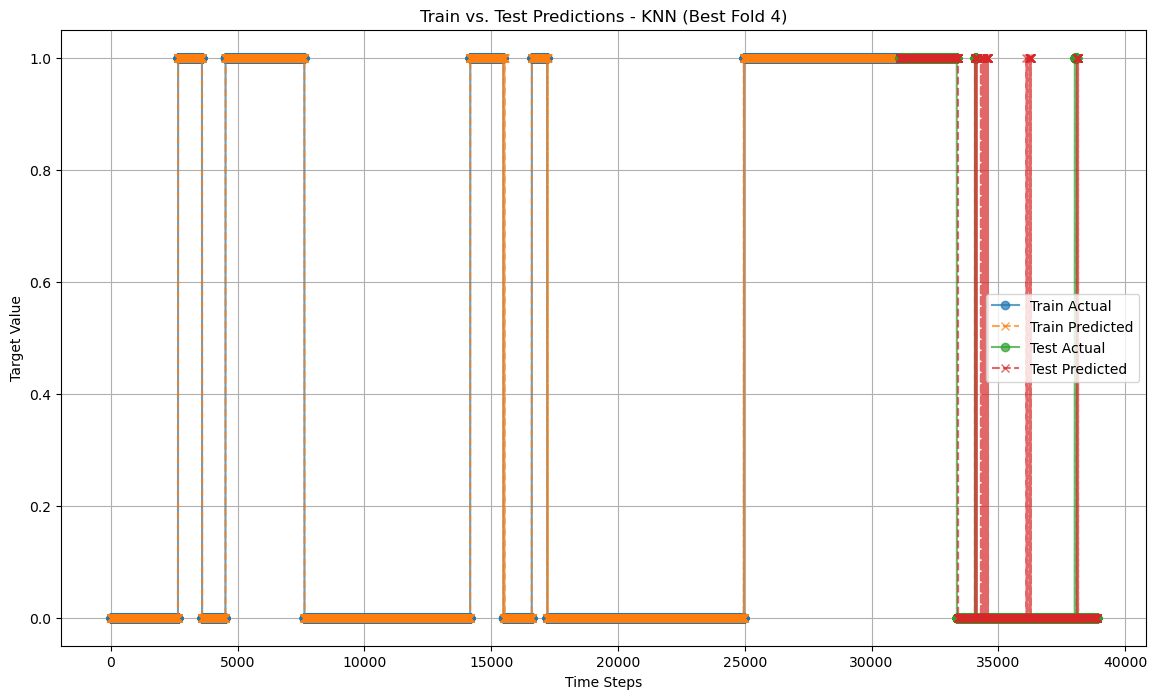

Training SVC...
Skipping fold 5 for SVC due to lack of class diversity in y_test.

SVC Results:
Train: F1=0.9976, Precision=0.9954, Recall=0.9998, ROC AUC=1.0000
Test:  F1=0.2629, Precision=0.4870, Recall=0.2533, ROC AUC=0.9141


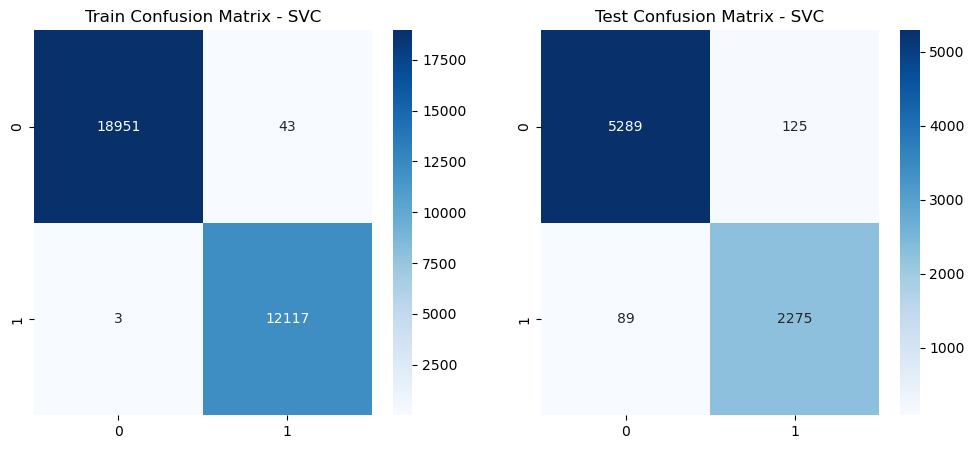

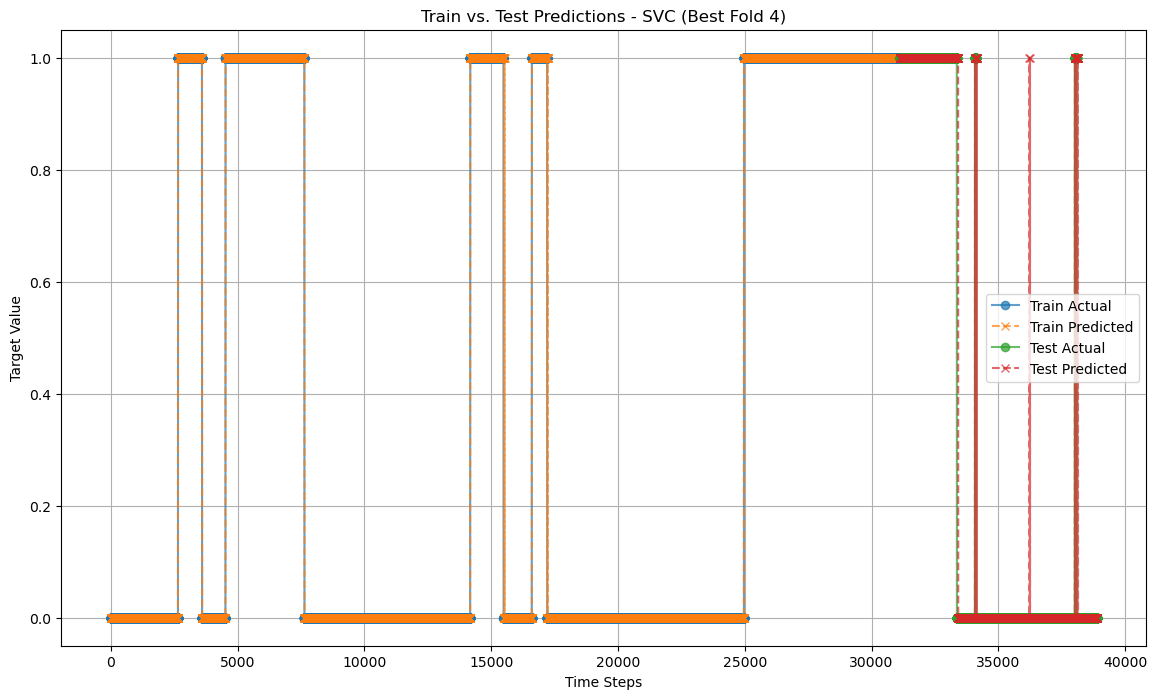

Training CART...
Skipping fold 5 for CART due to lack of class diversity in y_test.

CART Results:
Train: F1=1.0000, Precision=1.0000, Recall=1.0000, ROC AUC=1.0000
Test:  F1=0.3590, Precision=0.5692, Recall=0.3193, ROC AUC=0.6440


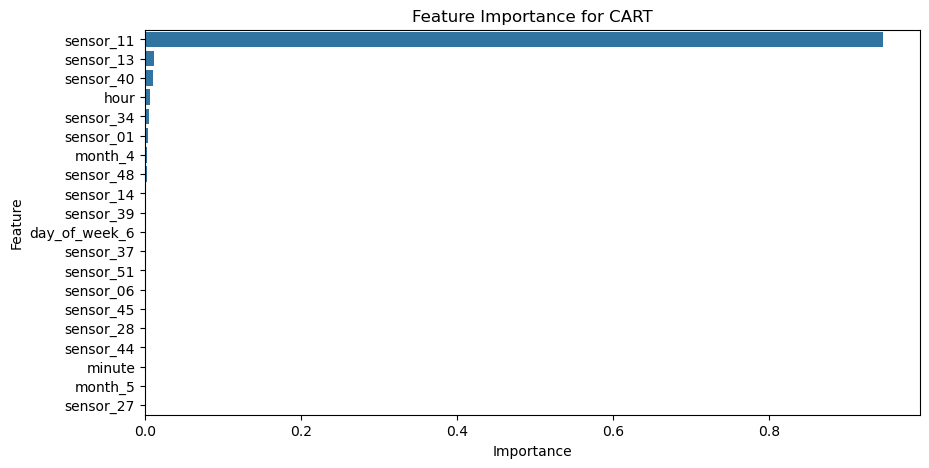

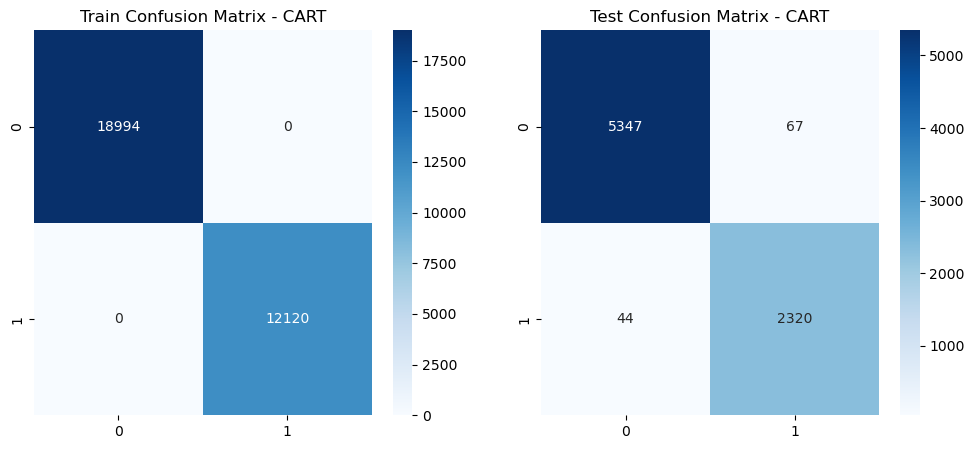

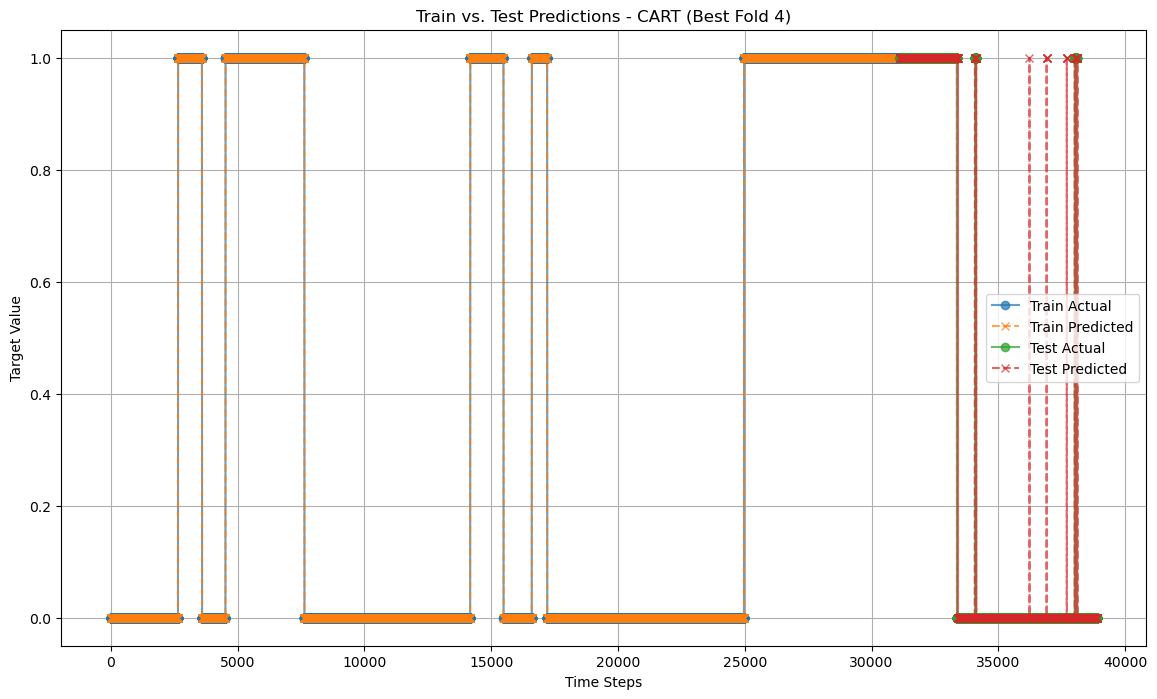

Training RF...
Skipping fold 5 for RF due to lack of class diversity in y_test.

RF Results:
Train: F1=1.0000, Precision=1.0000, Recall=1.0000, ROC AUC=1.0000
Test:  F1=0.5128, Precision=0.8869, Recall=0.4311, ROC AUC=0.9959


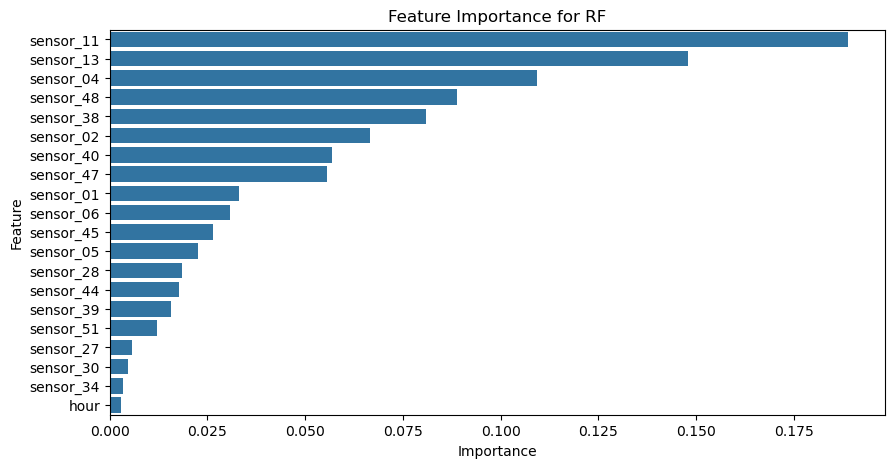

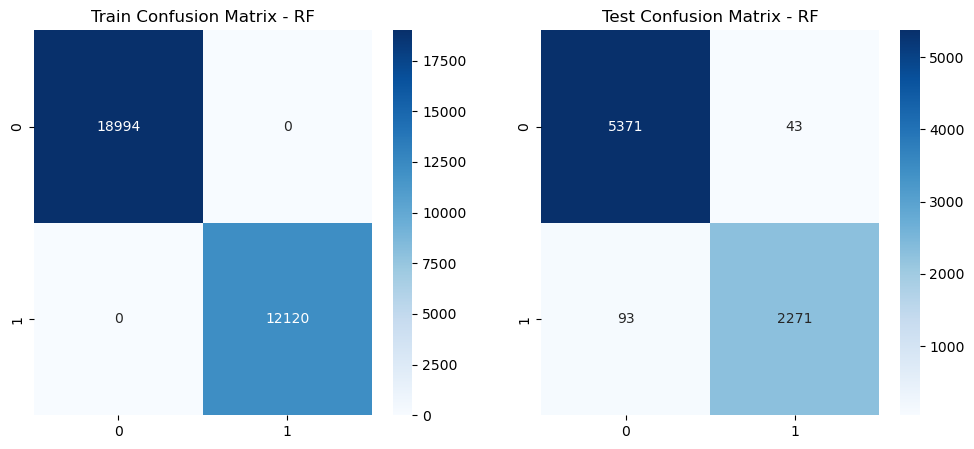

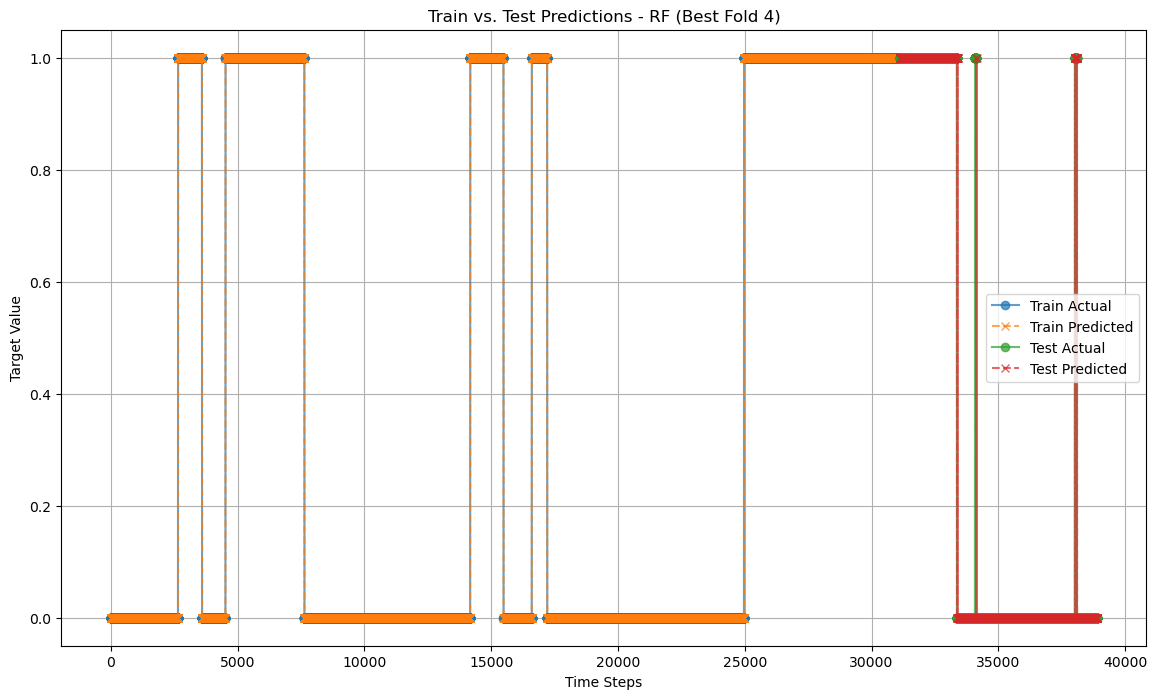

Training Adaboost...
Skipping fold 5 for Adaboost due to lack of class diversity in y_test.

Adaboost Results:
Train: F1=0.9996, Precision=0.9994, Recall=0.9998, ROC AUC=1.0000
Test:  F1=0.5354, Precision=0.6684, Recall=0.5188, ROC AUC=0.9940


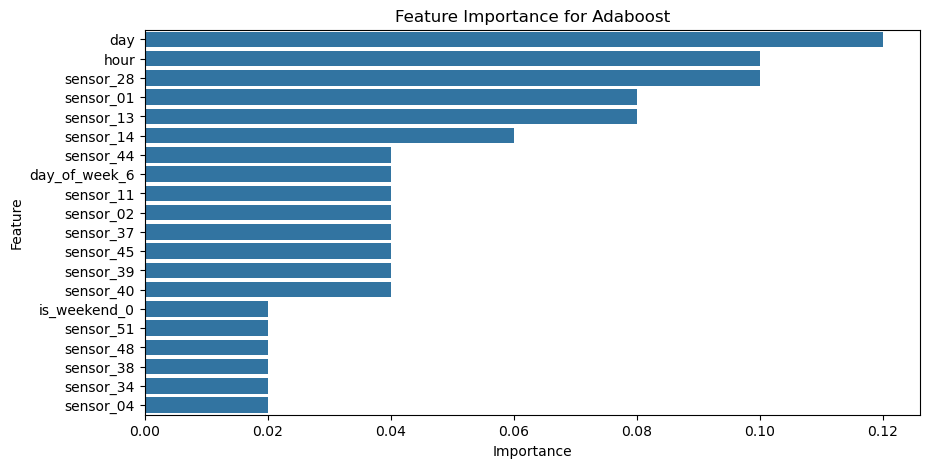

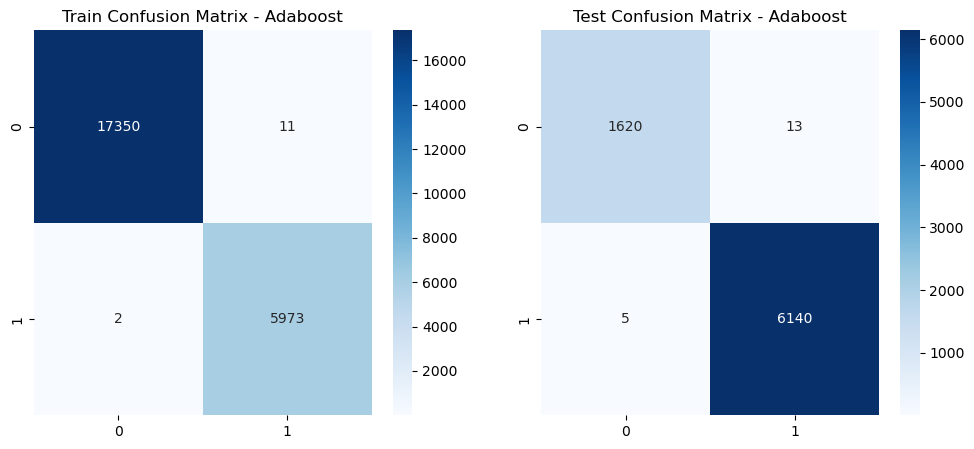

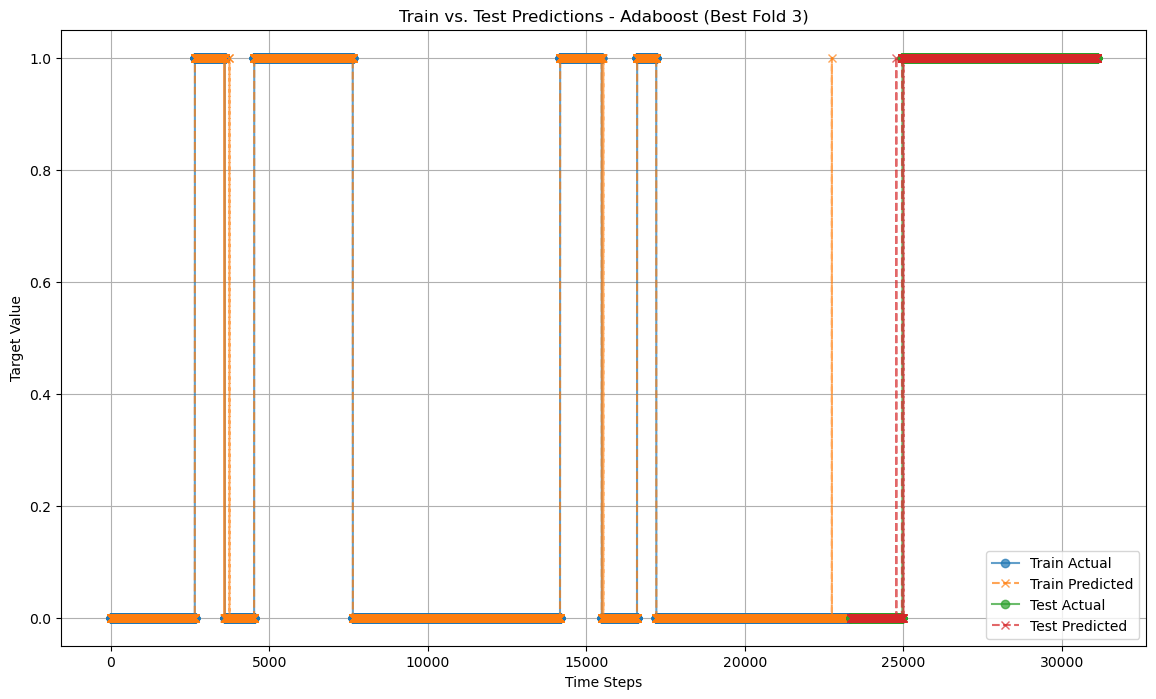

Training GBM...
Skipping fold 5 for GBM due to lack of class diversity in y_test.

GBM Results:
Train: F1=0.9996, Precision=0.9993, Recall=0.9999, ROC AUC=1.0000
Test:  F1=0.8591, Precision=0.9425, Recall=0.7955, ROC AUC=0.9949


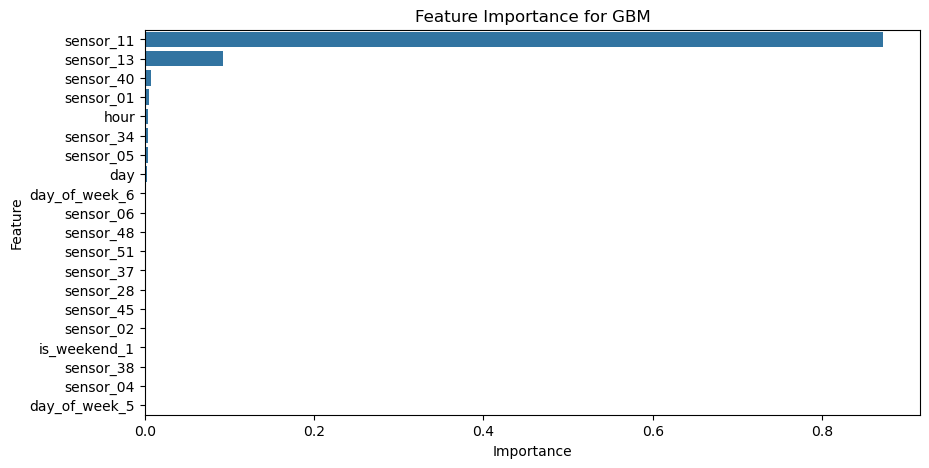

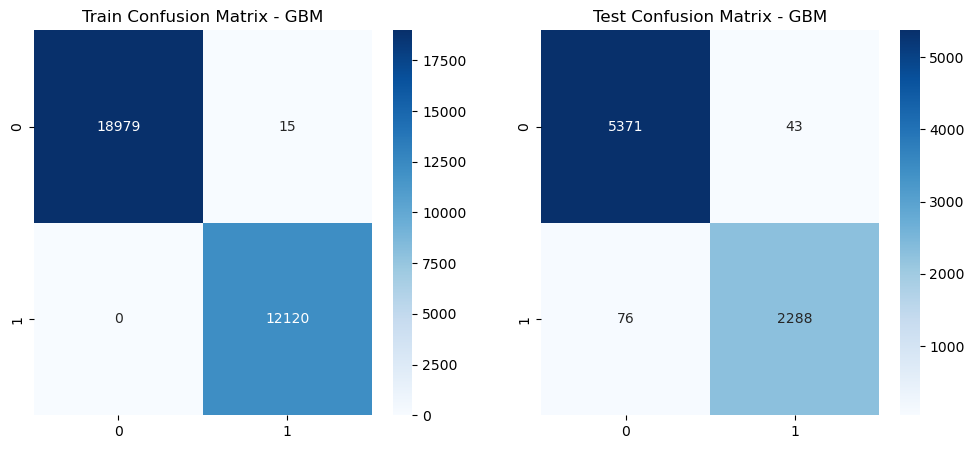

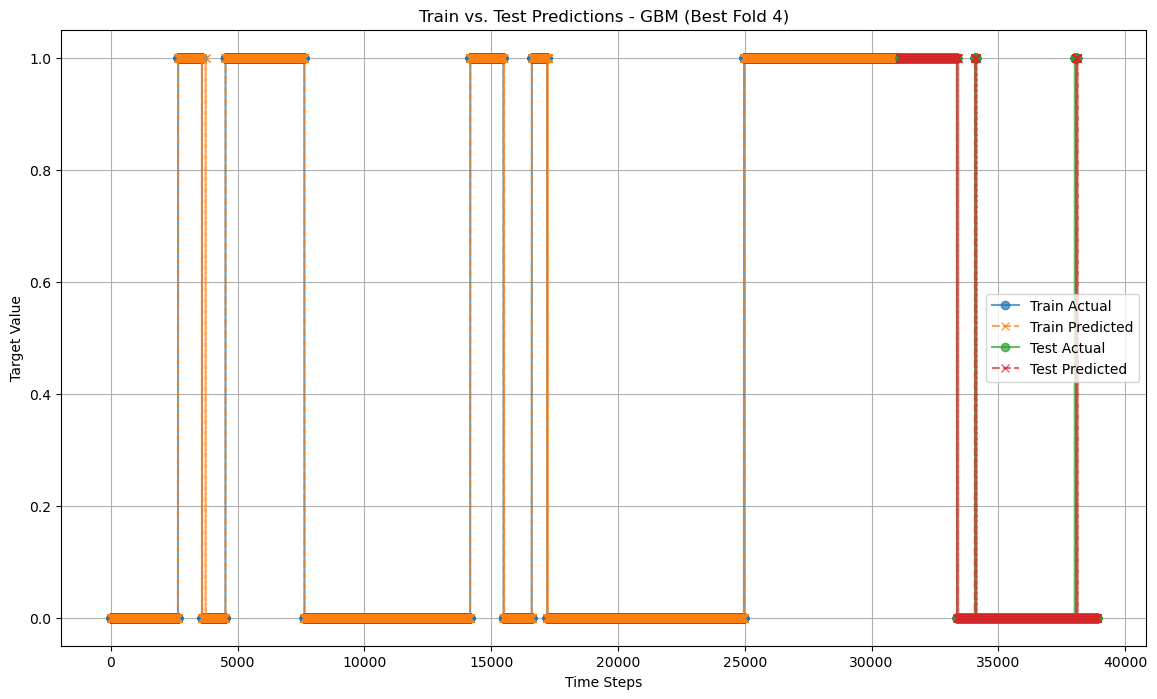

Training XGBoost...
Skipping fold 5 for XGBoost due to lack of class diversity in y_test.

XGBoost Results:
Train: F1=1.0000, Precision=1.0000, Recall=1.0000, ROC AUC=1.0000
Test:  F1=0.6517, Precision=0.7372, Recall=0.6035, ROC AUC=0.9792


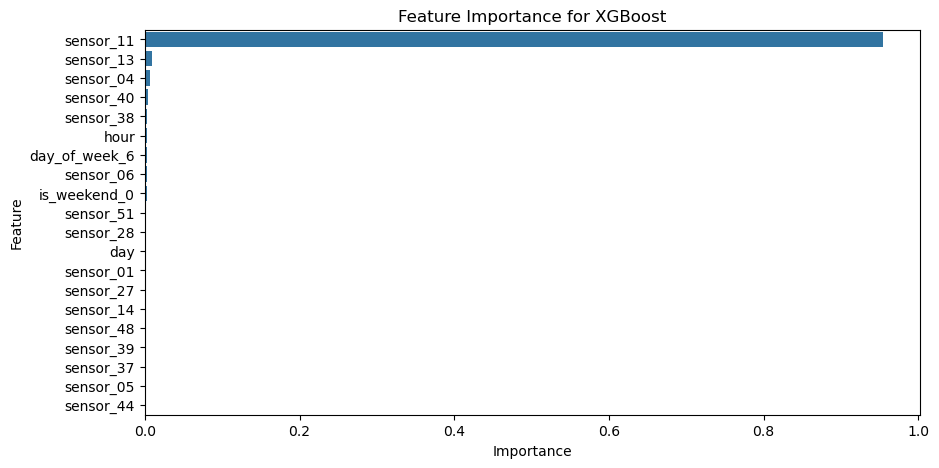

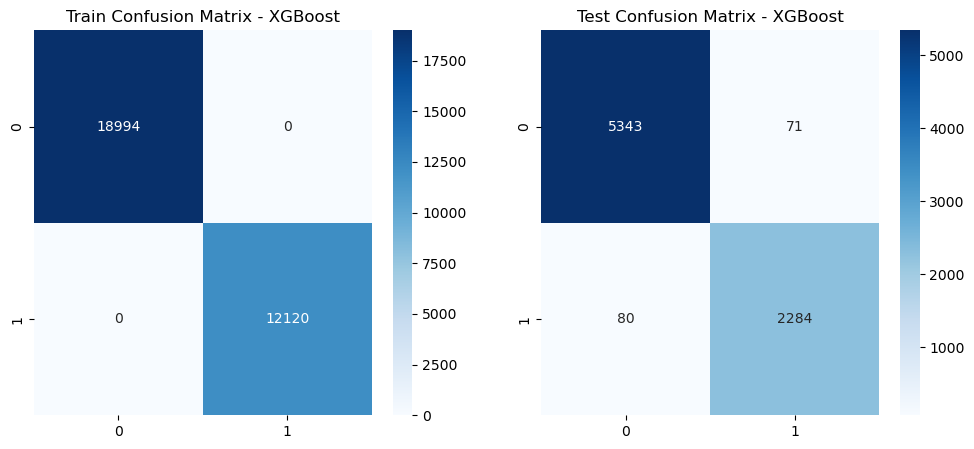

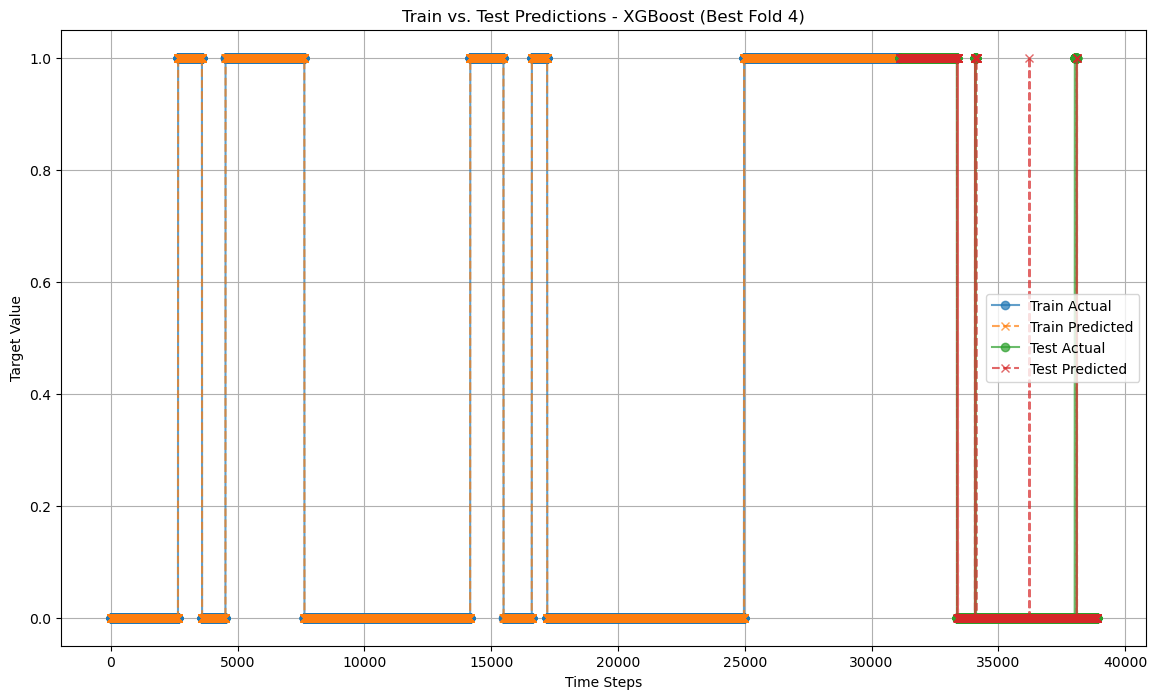

Training LightGBM...
Skipping fold 5 for LightGBM due to lack of class diversity in y_test.

LightGBM Results:
Train: F1=1.0000, Precision=1.0000, Recall=1.0000, ROC AUC=1.0000
Test:  F1=0.5930, Precision=0.7483, Recall=0.5398, ROC AUC=0.9337


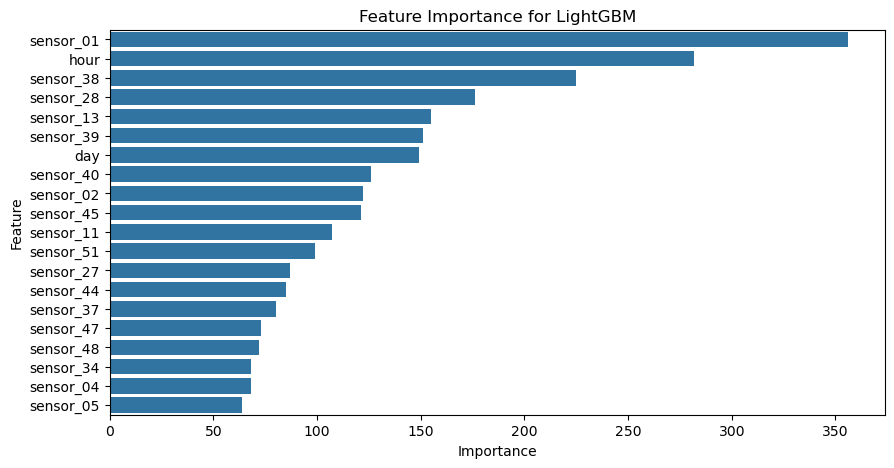

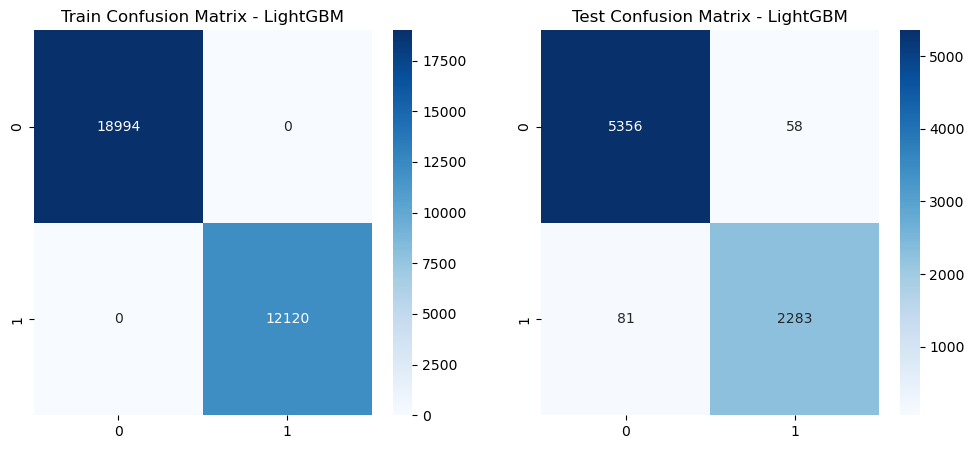

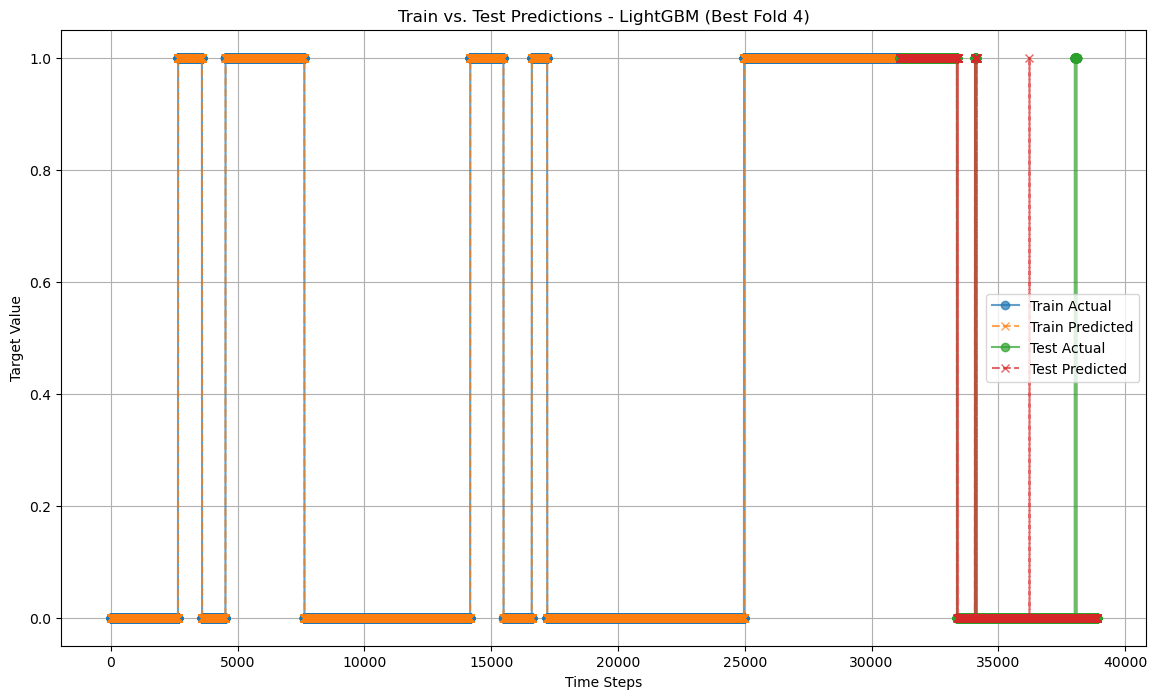


Final Model Performance Summary:
LR: Train F1=0.9907, Test F1=0.6254
KNN: Train F1=0.9989, Test F1=0.2369
SVC: Train F1=0.9976, Test F1=0.2629
CART: Train F1=1.0000, Test F1=0.3590
RF: Train F1=1.0000, Test F1=0.5128
Adaboost: Train F1=0.9996, Test F1=0.5354
GBM: Train F1=0.9996, Test F1=0.8591
XGBoost: Train F1=1.0000, Test F1=0.6517
LightGBM: Train F1=1.0000, Test F1=0.5930


In [133]:
# Evaluate Models without lags
results = evaluate_models_with_plots(train_X_scaled, train_y_balanced)

The model performance summary indicates varying degrees of overfitting and generalization across different algorithms. While most models achieve near-perfect F1 scores on the training set, their performance on the test set reveals significant differences in generalization ability. 

Key observations:
- **GBM** demonstrates the highest Test F1 score (0.8591), suggesting it generalizes the best among all models.
- **XGBoost** follows with a Test F1 score of 0.6517, showing strong performance but slightly less generalization compared to GBM.
- **Logistic Regression (LR)** achieves a Test F1 score of 0.6254, reflecting moderate generalization despite a much lower training F1 score compared to other models.
- **Adaboost** achieves a Test F1 score of 0.5354, showcasing reasonable performance.

The remaining models (KNN, SVC, CART, RF, and LightGBM) either exhibit significant overfitting or comparatively lower test F1 scores.

### Next Steps:
To further improve performance, hyperparameter tuning will be performed on the top four models with the highest Test F1 scores: **GBM, XGBoost, Logistic Regression, and Adaboost**. This will help optimize their parameters and achieve better balance between training and test performance.

# Hyperparameter Optimization

In [152]:
def hyperparameter_optimization_and_evaluation(X, y):
    print("Starting Hyperparameter Optimization...\n")

    classifiers = {
        'LR': (LogisticRegression(max_iter=1000, class_weight='balanced'), {
            'C': [0.01, 0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs']
        }),
        'Adaboost': (AdaBoostClassifier(), {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1],
        }),
        'GBM': (GradientBoostingClassifier(), {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
        }),
        'XGBoost': (XGBClassifier(eval_metric='logloss'), {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [50, 100, 200],
        })
    }

    tscv = TimeSeriesSplit(n_splits=5)
    best_models = {}
    tuning_results = []

    for name, (model, params) in classifiers.items():
        print(f"Tuning {name}...")

        grid_search = GridSearchCV(
            estimator=model,
            param_grid=params,
            scoring=make_scorer(f1_score, average='weighted', zero_division=0),
            cv=tscv,
            n_jobs=-1,
            verbose=1,
        )
        grid_search.fit(X, y)

        best_models[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_params': grid_search.best_params_,
        }

        print(f"{name} Best Parameters: {grid_search.best_params_}\n")
        print(f"F1 Score (Best Model): {grid_search.best_score_:.4f}\n")

        # Evaluate best model
        test_metrics = {'f1': []}
        train_metrics = {'f1': []}

        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            model = grid_search.best_estimator_
            model.fit(X_train, y_train)

            train_pred = model.predict(X_train)
            test_pred = model.predict(X_test)

            train_metrics['f1'].append(f1_score(y_train, train_pred, average='weighted', zero_division=0))
            test_metrics['f1'].append(f1_score(y_test, test_pred, average='weighted', zero_division=0))

        mean_train_metrics = {k: np.mean(v) for k, v in train_metrics.items()}
        mean_test_metrics = {k: np.mean(v) for k, v in test_metrics.items()}

        tuning_results.append((name, mean_train_metrics, mean_test_metrics))

        print(f"{name} Training F1 Score: {mean_train_metrics['f1']:.4f}")
        print(f"{name} Test F1 Score: {mean_test_metrics['f1']:.4f}\n")

    # Determine best model based on test F1 score
    best_model_name = None
    best_test_f1 = 0
    best_model_details = None

    for model_name, train_metrics, test_metrics in tuning_results:
        if test_metrics['f1'] > best_test_f1:
            best_test_f1 = test_metrics['f1']
            best_model_name = model_name
            best_model_details = {
                'train_f1': train_metrics['f1'],
                'test_f1': test_metrics['f1'],
                'model': best_models[model_name]['best_estimator'],
                'params': best_models[model_name]['best_params']
            }

    print("\nBest Model Based on Test F1 Score:")
    print(f"Model Name: {best_model_name}")
    print(f"Training F1 Score: {best_model_details['train_f1']:.4f}")
    print(f"Test F1 Score: {best_model_details['test_f1']:.4f}")
    print(f"Best Hyperparameters: {best_model_details['params']}")

    # Save the best model
    best_model = best_model_details['model']
    joblib.dump(best_model, 'best_model.pkl')
    print("\nBest model saved as 'best_model.pkl'.")

    # Retrain the best model on the entire training data
    best_model.fit(X, y)

    # Feature Importance (Top 15)
    if hasattr(best_model, 'feature_importances_'):
        feature_importances = best_model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False).head(15)

        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
        plt.title("Top 15 Features by Importance")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.gca().invert_yaxis()  # Invert the order to have the most important on top
        plt.show()

    # Confusion Matrix
    y_pred = best_model.predict(X)
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y, y_pred, zero_division=0))

    return best_models, tuning_results, best_model

Starting Hyperparameter Optimization...

Tuning LR...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
LR Best Parameters: {'C': 0.1, 'solver': 'lbfgs'}

F1 Score (Best Model): 0.9473

LR Training F1 Score: 0.9904
LR Test F1 Score: 0.9473

Tuning Adaboost...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Adaboost Best Parameters: {'learning_rate': 0.01, 'n_estimators': 100}

F1 Score (Best Model): 0.9914

Adaboost Training F1 Score: 0.9893
Adaboost Test F1 Score: 0.9914

Tuning GBM...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
GBM Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

F1 Score (Best Model): 0.9676

GBM Training F1 Score: 0.9979
GBM Test F1 Score: 0.9698

Tuning XGBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
XGBoost Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}

F1 Score (Best Model): 0.9806

XGBoost Training F1 Score: 0.9945
XGBoost Test F1 Score: 

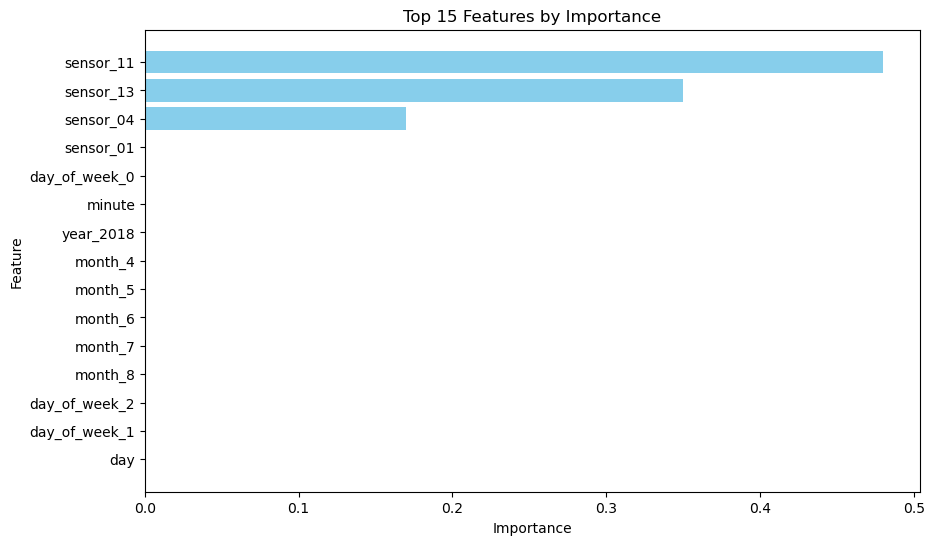

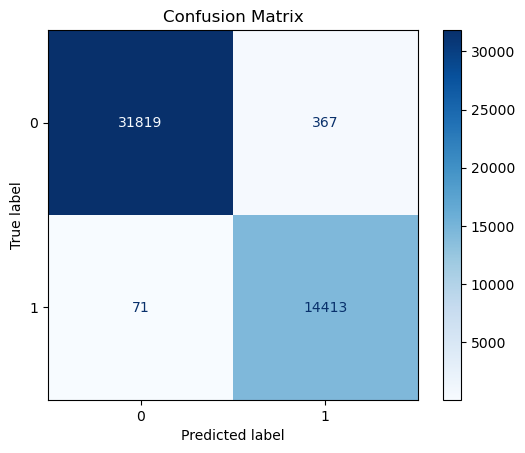


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     32186
           1       0.98      1.00      0.99     14484

    accuracy                           0.99     46670
   macro avg       0.99      0.99      0.99     46670
weighted avg       0.99      0.99      0.99     46670

Tuning Results:

LR: Training F1 Score = 0.9904, Test F1 Score = 0.9473
Adaboost: Training F1 Score = 0.9893, Test F1 Score = 0.9914
GBM: Training F1 Score = 0.9979, Test F1 Score = 0.9698
XGBoost: Training F1 Score = 0.9945, Test F1 Score = 0.9806


In [154]:
best_models, tuning_results, best_model = hyperparameter_optimization_and_evaluation(train_X_scaled, train_y_balanced)

# Print Final Tuning Results
print("Tuning Results:\n")
for model_name, train_metrics, test_metrics in tuning_results:
    print(f"{model_name}: Training F1 Score = {train_metrics['f1']:.4f}, Test F1 Score = {test_metrics['f1']:.4f}")

**Summary & Recommendations:**

* Best Performing Model: XGBoost appears to be the best model overall, based on its test F1 score (0.9806). It has a great balance between training and test F1 scores, making it a reliable model for generalization.

* Second Best: AdaBoost also performs very well, particularly in terms of test F1 score (0.9914), even though its training F1 score is slightly lower than the others. It might be a good alternative for a model that generalizes well to unseen data.

* Potential Overfitting: Gradient Boosting has a high training F1 score (0.9979), but its drop in the test F1 score (0.9698) suggests that it might be overfitting, and thus may not generalize as well to new data.

* Logistic Regression shows a good performance but with a more noticeable drop in test F1 score (0.9473). While it's fast and interpretable, its performance on unseen data is not as strong as the ensemble methods (AdaBoost, GBM, and XGBoost).

**Next Steps:**
Consider fine-tuning the XGBoost model further to improve its performance or even experiment with stacking models (e.g., combining predictions from XGBoost and AdaBoost for potentially better performance).
Also, keep an eye on AdaBoost, as it generalizes well on the test set, which is crucial in many real-world applications.
By focusing on XGBoost or AdaBoost, we're likely to get the best results for our task.

# Conclusion

**Function Definitions:**

Generic functions (check_df, grab_col_names) were included to simplify and automate tasks like data overview, data type checks, and variable identification.

**Exploratory Data Analysis:**

Summarized the dataset's shape, null values, and descriptive statistics for numerical columns.
Identified categorical, numerical, and high-cardinality features.
Addressed missing values and potential data type issues.

**Preprocessing & Feature Engineering (Assuming subsequent cells continue the work):**

Potential transformations on categorical features and feature engineering may have been applied.
Normalization and standardization for numerical variables might have been processed.
Derived useful insights from initial exploratory visualizations.

**Future Model/Analysis Preparation:**

The data preprocessing laid the foundation for machine learning or other analytic tasks.

**Advice for Next Tasks**

**Advanced Feature Engineering:**

Investigate interactions between features or develop new derived variables.
Address any remaining outliers or highly skewed variables.

**Modeling and Evaluation:**

Use the cleaned dataset to train predictive models (e.g., regression, classification, or clustering, depending on the context).
Validate models using k-fold cross-validation and optimize hyperparameters.

**Visual Insights:**

Summarize key findings into impactful visualizations that reflect data trends or segmentation insights.